In [1]:
#pip install xgboost

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import uniform, randint


from tempfile import mkdtemp
import re

from xgboost import XGBRegressor

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor,  HistGradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data = pd.read_csv('data/train.csv', index_col = 'Id')
X_test = pd.read_csv('data/test.csv')
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [5]:
X_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,Hd

In [6]:
X = data.drop(columns = 'SalePrice')
y = data['SalePrice']

X.shape, y.shape

((1460, 79), (1460,))

# Baseline model

## Custom Scorer (RMSLE)

In [7]:
RMSLE = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred) ** 0.5)
neg_RMSLE = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred) ** 0.5)

In [8]:
X = data.drop(columns = 'SalePrice')
y = data['SalePrice']

X.shape, y.shape

((1460, 79), (1460,))

## Feature overview

In [9]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
Name: count, dtype: int64

In [10]:
cat_feat_nunique = X.select_dtypes(include = 'object').nunique()
cat_feat_nunique.sum()

251

In [11]:
# Too many features! 

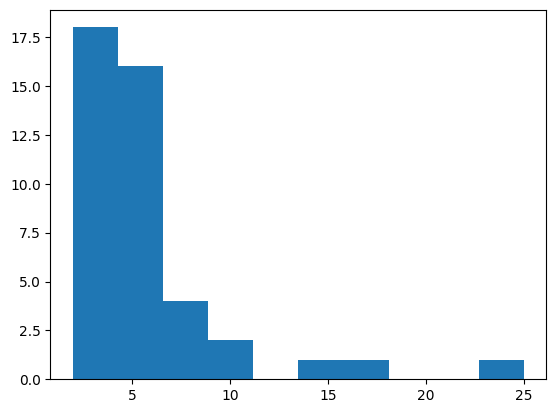

In [12]:
# Histogram of Number of unique values per categorical feature
plt.hist(cat_feat_nunique);

In [13]:
cat_feat_small = list(cat_feat_nunique[cat_feat_nunique < 7].index)
len(cat_feat_small)

34

## Baseline Pipe

### Preprocessing

In [14]:
bs_num_preprocessor = make_pipeline(SimpleImputer(), MinMaxScaler())

bs_cat_preprocessor = make_pipeline(SimpleImputer(strategy = 'most_frequent'), OneHotEncoder(handle_unknown = 'ignore'))

bs_preprocessor = make_column_transformer(
    (bs_num_preprocessor, make_column_selector(dtype_include = ['int64', 'float64'])),
    (bs_cat_preprocessor, cat_feat_small),
    remainder = 'drop'
)
    
bs_preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17f6e3560>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

### Estimator

In [15]:
bs_pipe = make_pipeline(bs_preprocessor, DecisionTreeRegressor())
bs_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17f6e3560>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder'...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

### CV

In [16]:
bs_cv_score = cross_val_score(bs_pipe, X, y, cv = 5, scoring = RMSLE).mean()
bs_cv_score

0.21025767665032294

### Predict

In [17]:
bs_X_test = pd.read_csv('data/test.csv')
bs_X_test_ids = bs_X_test['Id']
bs_X_test = bs_X_test.drop(columns =['Id'])

bs_pipe.fit(X, y)
bs_y_pred = bs_pipe.predict(bs_X_test)
bs_results = pd.concat([bs_X_test_ids, pd.Series(bs_y_pred, name = 'SalePrice')], axis = 1)
bs_results

,Id,SalePrice
0,1461,129000.0
1,1462,157900.0
2,1463,192000.0
3,1464,178000.0
4,1465,213500.0
...,...,...
1454,2915,84500.0
1455,2916,83000.0
1456,2917,139000.0
1457,2918,103200.0


#  Data preperation for Modelling

## Preprocessing

### EDA

In [18]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
Name: count, dtype: int64

In [19]:
X_num = X.select_dtypes(include = ['int64', 'float64'])
X_cat = X.select_dtypes(include = 'object')

In [20]:
X_num.describe().map(lambda x: round(x))

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460,1201,1460,1460,1460,1460,1460,1452,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1379,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
mean,57,70,10517,6,6,1971,1985,104,444,47,567,1057,1163,347,6,1515,0,0,2,0,3,1,7,1,1979,2,473,94,47,22,3,15,3,43,6,2008
std,42,24,9981,1,1,30,21,181,456,161,442,439,387,437,49,525,1,0,1,1,1,0,2,1,25,1,214,125,66,61,29,56,40,496,3,1
min,20,21,1300,1,1,1872,1950,0,0,0,0,0,334,0,0,334,0,0,0,0,0,0,2,0,1900,0,0,0,0,0,0,0,0,0,1,2006
25%,20,59,7554,5,5,1954,1967,0,0,0,223,796,882,0,0,1130,0,0,1,0,2,1,5,0,1961,1,334,0,0,0,0,0,0,0,5,2007
50%,50,69,9478,6,5,1973,1994,0,384,0,478,992,1087,0,0,1464,0,0,2,0,3,1,6,1,1980,2,480,0,25,0,0,0,0,0,6,2008
75%,70,80,11602,7,6,2000,2004,166,712,0,808,1298,1391,728,0,1777,1,0,2,1,3,1,7,1,2002,2,576,168,68,0,0,0,0,0,8,2009
max,190,313,215245,10,9,2010,2010,1600,5644,1474,2336,6110,4692,2065,572,5642,3,2,3,2,8,3,14,3,2010,4,1418,857,547,552,508,480,738,15500,12,2010


In [21]:
X_cat.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


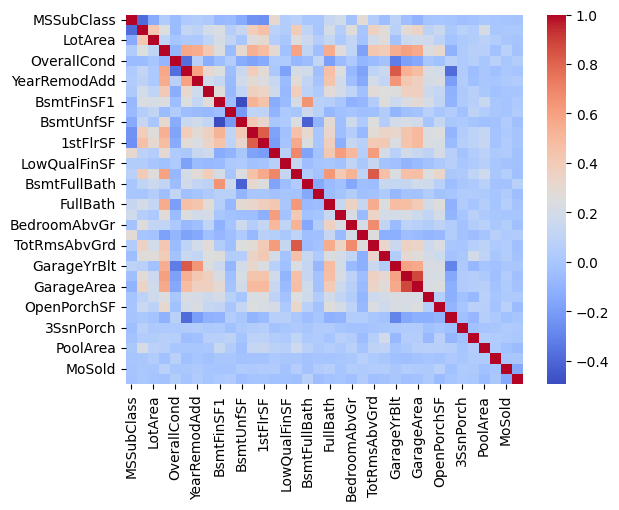

In [22]:
sns.heatmap(X_num.corr(), cmap = 'coolwarm');

### Remove Duplicates

In [23]:
data.duplicated().sum()

0

In [24]:
X_test.duplicated().sum()

0

### Impute or Remove Missing Values

In [25]:
data.isnull().sum().sort_values(ascending = False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
MSSubClass         0
dtype: int64

In [26]:
X_test.isnull().sum().sort_values(ascending = False).head(21)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
dtype: int64

#### Imputing Features with 'None'

In [27]:
none_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 'BsmtExposure', 'BsmtFinType2', 'BsmtCond', 'BsmtFinType1', 'BsmtQual']

In [28]:
none_imputer = SimpleImputer(strategy = 'constant', fill_value = 'None')
data[none_features] = none_imputer.fit_transform(data[none_features])
X_test[none_features] = none_imputer.fit_transform(X_test[none_features])
data[none_features]

,PoolQC,MiscFeature,Alley,Fence,MasVnrType,FireplaceQu,BsmtExposure,BsmtFinType2,BsmtCond,BsmtFinType1,BsmtQual
Id,,,,,,,,,,,
1,None,None,None,None,BrkFace,None,No,Unf,TA,GLQ,Gd
2,None,None,None,None,None,TA,Gd,Unf,TA,ALQ,Gd
3,None,None,None,None,BrkFace,TA,Mn,Unf,TA,GLQ,Gd
4,None,None,None,None,None,Gd,No,Unf,Gd,ALQ,TA
5,None,None,None,None,BrkFace,TA,Av,Unf,TA,GLQ,Gd
...,...,...,...,...,...,...,...,...,...,...,...
1456,None,None,None,None,None,TA,No,Unf,TA,Unf,Gd
1457,None,None,None,MnPrv,Stone,TA,No,Rec,TA,ALQ,Gd
1458,None,Shed,None,GdPrv,None,Gd,No,Unf,Gd,GLQ,TA


#### Imputing numerical_values

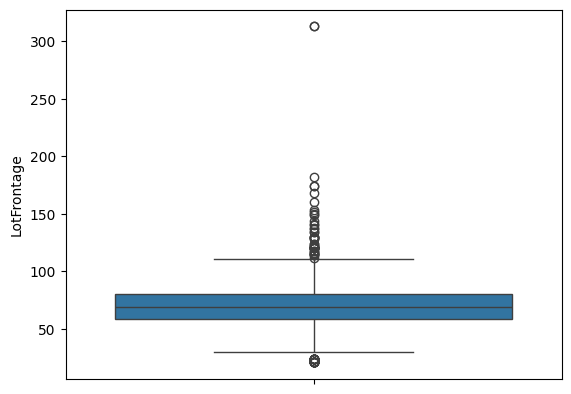

In [29]:
sns.boxplot(data = data['LotFrontage']);

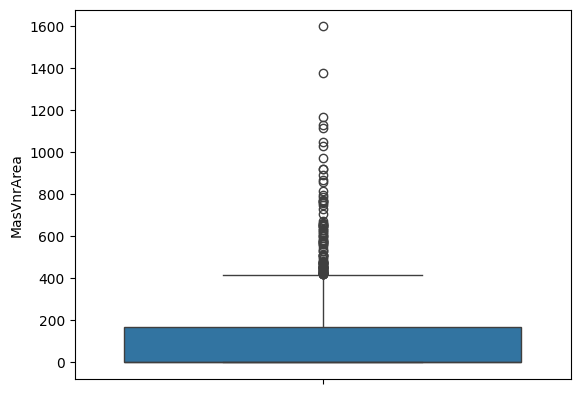

In [30]:
sns.boxplot(data = data['MasVnrArea']);

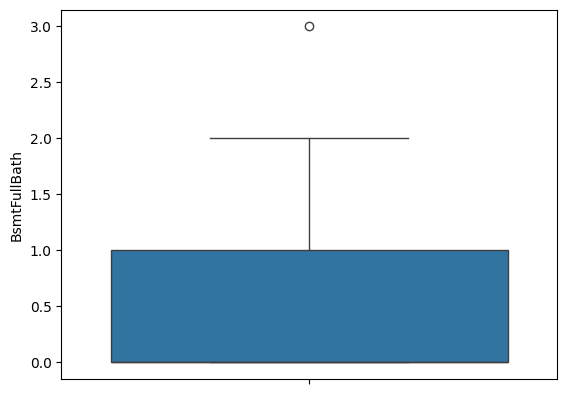

In [31]:
sns.boxplot(data = X_test['BsmtFullBath']);

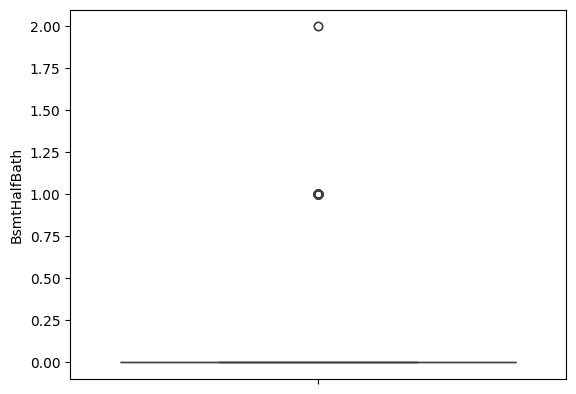

In [32]:
sns.boxplot(data = X_test['BsmtHalfBath']);

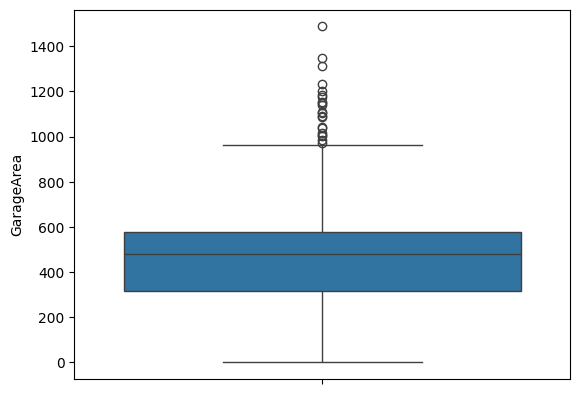

In [33]:
sns.boxplot(data = X_test['GarageArea']);

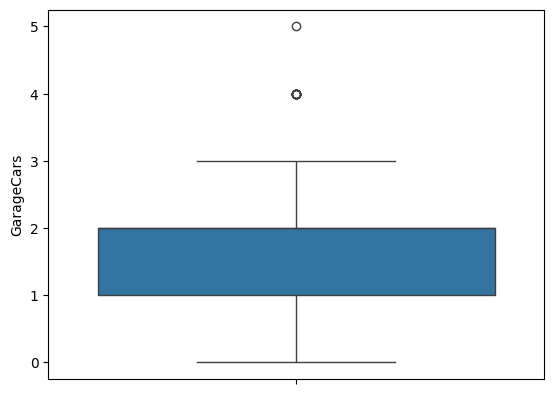

In [34]:
sns.boxplot(data = X_test['GarageCars']);

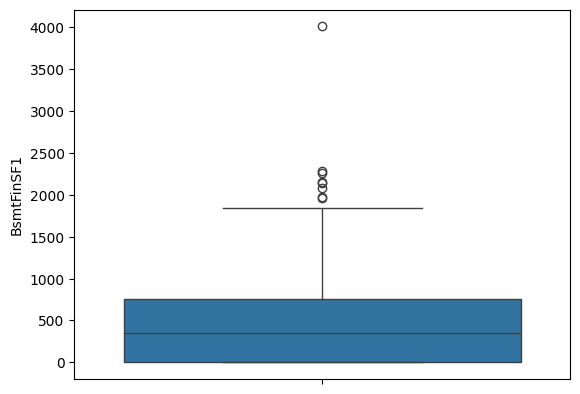

In [35]:
sns.boxplot(data = X_test['BsmtFinSF1']);

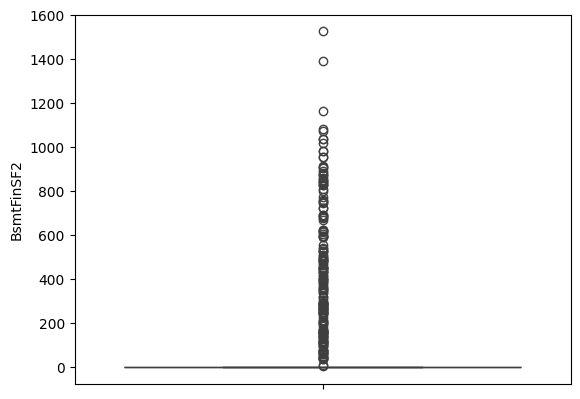

In [36]:
sns.boxplot(data = X_test['BsmtFinSF2']);

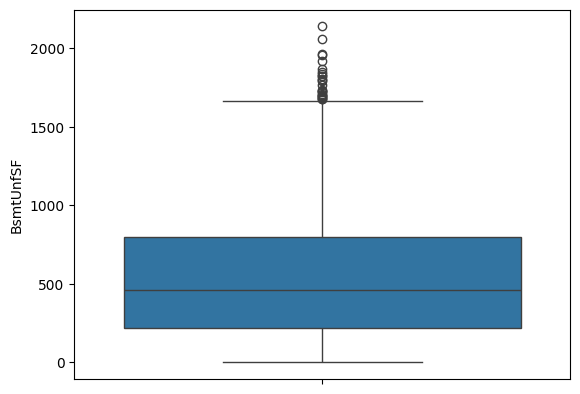

In [37]:
sns.boxplot(data = X_test['BsmtUnfSF']);

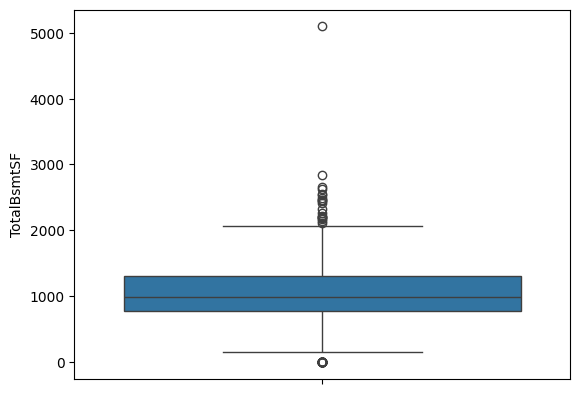

In [38]:
sns.boxplot(data = X_test['TotalBsmtSF']);

In [39]:
# Many outliers -> Median
median_imputer = SimpleImputer(strategy = 'median')
data[['LotFrontage', 'MasVnrArea']] = median_imputer.fit_transform(data[['LotFrontage', 'MasVnrArea']])
X_test[['LotFrontage', 'MasVnrArea','BsmtFullBath', 'BsmtHalfBath', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']] = median_imputer.fit_transform(X_test[['LotFrontage', 'MasVnrArea','BsmtFullBath', 'BsmtHalfBath', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']])

#### Impute categorical feature which has no 'none' scanerio

In [40]:
mode_imputer = SimpleImputer(strategy = 'most_frequent')
data[['Electrical']] = mode_imputer.fit_transform(data[['Electrical']])
X_test[['Electrical', 'MSZoning', 'Functional', 'Utilities','Exterior2nd', 'KitchenQual', 'Exterior1st', 'SaleType' ]] = mode_imputer.fit_transform(X_test[['Electrical', 'MSZoning', 'Functional', 'Utilities','Exterior2nd', 'KitchenQual', 'Exterior1st', 'SaleType']])

#### Garage

In [41]:
pd.set_option('display.max_rows', None)
garage_df  = data[['GarageYrBlt', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual']]
garage_df = pd.concat([garage_df[garage_df.isna().any(axis = 1)], data[['GarageCars', 'GarageArea']]], axis = 1)
garage_df.head(81)

,GarageYrBlt,GarageCond,GarageType,GarageFinish,GarageQual,GarageCars,GarageArea
Id,,,,,,,
40,NaN,NaN,NaN,NaN,NaN,0,0
49,NaN,NaN,NaN,NaN,NaN,0,0
79,NaN,NaN,NaN,NaN,NaN,0,0
89,NaN,NaN,NaN,NaN,NaN,0,0
90,NaN,NaN,NaN,NaN,NaN,0,0
100,NaN,NaN,NaN,NaN,NaN,0,0
109,NaN,NaN,NaN,NaN,NaN,0,0
126,NaN,NaN,NaN,NaN,NaN,0,0
128,NaN,NaN,NaN,NaN,NaN,0,0


In [42]:
pd.set_option('display.max_rows', 60)

In [43]:
data[['GarageCond', 'GarageType', 'GarageFinish', 'GarageQual']] = none_imputer.fit_transform(data[['GarageCond', 'GarageType', 'GarageFinish', 'GarageQual']])
X_test[['GarageCond', 'GarageType', 'GarageFinish', 'GarageQual']] = none_imputer.fit_transform(X_test[['GarageCond', 'GarageType', 'GarageFinish', 'GarageQual']])

#### Final Check

In [44]:
data.isnull().sum().sort_values(ascending = False).head(20)

GarageYrBlt     81
MSSubClass       0
MSZoning         0
GarageType       0
FireplaceQu      0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
KitchenQual      0
KitchenAbvGr     0
BedroomAbvGr     0
HalfBath         0
FullBath         0
BsmtHalfBath     0
BsmtFullBath     0
GrLivArea        0
LowQualFinSF     0
2ndFlrSF         0
1stFlrSF         0
GarageFinish     0
dtype: int64

In [45]:
X_test.isnull().sum().sort_values(ascending = False).head(20)

GarageYrBlt     78
MSSubClass       0
GarageType       0
FireplaceQu      0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
KitchenQual      0
KitchenAbvGr     0
BedroomAbvGr     0
Id               0
FullBath         0
BsmtHalfBath     0
BsmtFullBath     0
GrLivArea        0
LowQualFinSF     0
2ndFlrSF         0
1stFlrSF         0
Electrical       0
HalfBath         0
dtype: int64

### Feature Engineering

#### Garage

In [46]:
# Creating new feature determining if there is a Garage, leaving NaNs, shouldn't impute Years in this case
data['Garage'] = (~ data['GarageYrBlt'].isnull()).astype(int)
X_test['Garage'] = (~ X_test['GarageYrBlt'].isnull()).astype(int)

#### Bsmt

In [47]:
# Hidden due to lentgh of dataframe (better to see whole df to tell what is going on with Basement)
#pd.set_option('display.max_rows', None)

In [48]:
data[['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']]

,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
Id,,,,,,
1,GLQ,706,Unf,0,150,856
2,ALQ,978,Unf,0,284,1262
3,GLQ,486,Unf,0,434,920
4,ALQ,216,Unf,0,540,756
5,GLQ,655,Unf,0,490,1145
...,...,...,...,...,...,...
1456,Unf,0,Unf,0,953,953
1457,ALQ,790,Rec,163,589,1542
1458,GLQ,275,Unf,0,877,1152


In [49]:
pd.set_option('display.max_rows', 60)

In [50]:
# Creating new feature determining if there is a Basement
data['Bsmt'] = data['TotalBsmtSF'].apply(lambda x : 1 if x > 0 else 0)
X_test['Bsmt'] = X_test['TotalBsmtSF'].apply(lambda x : 1 if x > 0 else 0)

#### Pool

In [51]:
# Creating new feature determining if there is a Pool
data['Pool'] = data['PoolQC'].apply(lambda x : 0 if x == 'None' else 1)
X_test['Pool'] = X_test['PoolQC'].apply(lambda x : 0 if x == 'None' else 1)

#### Fence

In [52]:
# Creating new feature determining if there is a fence
data['fence'] = data['Fence'].apply(lambda x : 0 if x == 'None' else 1)
X_test['fence'] = X_test['Fence'].apply(lambda x : 0 if x == 'None' else 1)

#### sin_MoSold, cos_MoSold (cyclical features)

In [53]:
months_in_a_year = 12

data['sin_MoSold'] = np.sin(2 * np.pi * (data['MoSold'] - 1) / months_in_a_year)
data['cos_MoSold'] = np.cos(2 * np.pi * (data['MoSold'] - 1) / months_in_a_year)

data.drop(columns = 'MoSold', inplace = True)

X_test['sin_MoSold'] = np.sin(2 * np.pi * (X_test['MoSold'] - 1) / months_in_a_year)
X_test['cos_MoSold'] = np.cos(2 * np.pi * (X_test['MoSold'] - 1) / months_in_a_year)

X_test.drop(columns = 'MoSold', inplace = True)

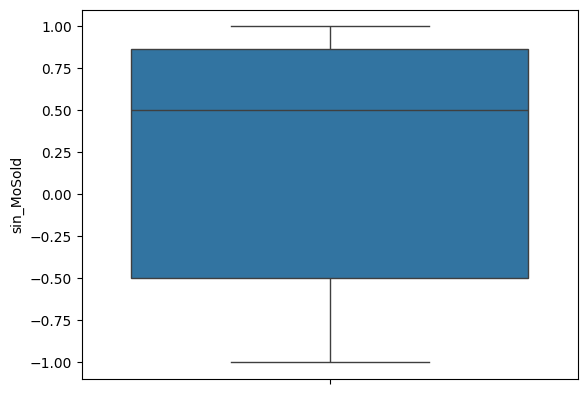

In [54]:
sns.boxplot(data['sin_MoSold']);

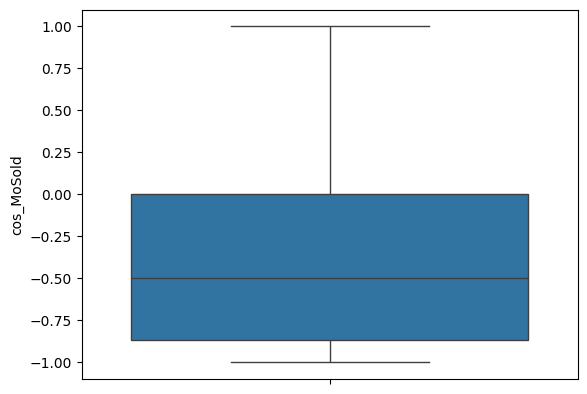

In [55]:
sns.boxplot(data['cos_MoSold']);

### Check for Outliers

#### BsmtFinSF1 (Type 1 finished square feet), TotalBsmtSF (Total square feet of basement area), 1stFlrSF (First Floor square feet) -> turned out to be one house, so probably no measurement error

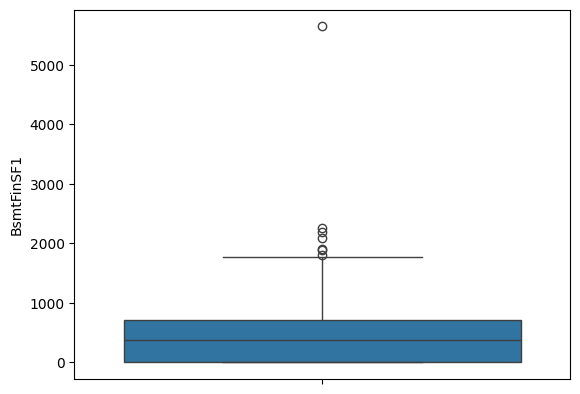

In [56]:
variable = 'BsmtFinSF1'
sns.boxplot(data = data[f"{variable}"]);

In [57]:
data[f"{variable}"].sort_values(ascending= False)

Id
1299    5644
524     2260
899     2188
1183    2096
179     1904
        ... 
446        0
106        0
983        0
984        0
867        0
Name: BsmtFinSF1, Length: 1460, dtype: int64

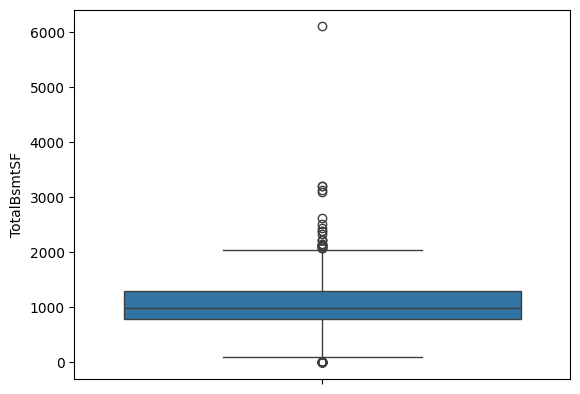

In [58]:
variable = 'TotalBsmtSF'
sns.boxplot(data = data[f"{variable}"]);

In [59]:
data[f"{variable}"].sort_values(ascending= False)

Id
1299    6110
333     3206
497     3200
524     3138
441     3094
        ... 
1413       0
1180       0
103        0
260        0
1049       0
Name: TotalBsmtSF, Length: 1460, dtype: int64

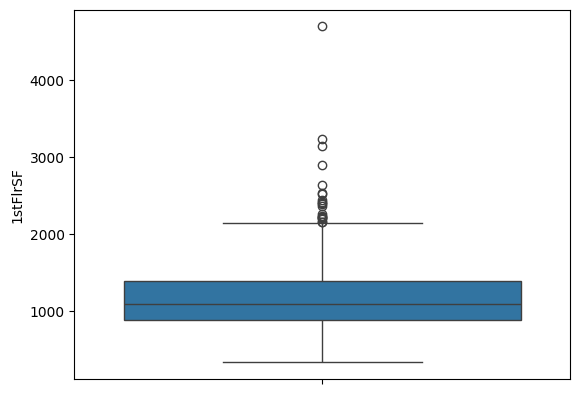

In [60]:
variable = '1stFlrSF'
sns.boxplot(data = data[f"{variable}"]);

In [61]:
data[f"{variable}"].sort_values(ascending = False)

Id
1299    4692
497     3228
524     3138
1025    2898
1374    2633
        ... 
431      483
917      480
1101     438
706      372
534      334
Name: 1stFlrSF, Length: 1460, dtype: int64

### Scailing numerical features

In [62]:
X = data.drop(columns = 'SalePrice')
y = data['SalePrice']

X.shape, y.shape

((1460, 84), (1460,))

In [63]:
X.dtypes.value_counts()

object     43
int64      36
float64     5
Name: count, dtype: int64

In [64]:
X_num = X.select_dtypes(include = ['int64', 'float64']).drop(columns = ['MSSubClass', 'OverallQual', 'OverallCond', 'Garage', 'Bsmt', 'Pool', 'fence', 'sin_MoSold', 'cos_MoSold']) 
X_cat = X.select_dtypes(include = ['object'])
X_cat['MSSubClass'] = X['MSSubClass']
X_cat['OverallQual'] = X['OverallQual']
X_cat['OverallCond'] = X['OverallCond']

In [65]:
X_num.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'YrSold'],
      dtype='object')

In [66]:
num_features = ['LotFrontage', 'LotArea',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'YrSold']

/var/folders/sm/vy1p0pvx0_xcgnggryx_11p80000gn/T/ipykernel_3079/3604918828.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,3,figsize=(15,5))


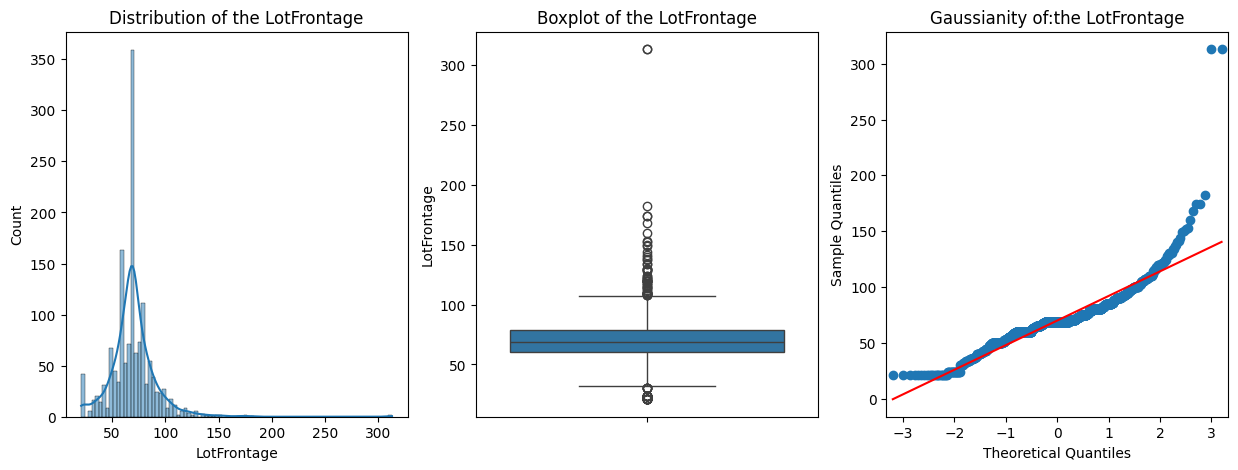

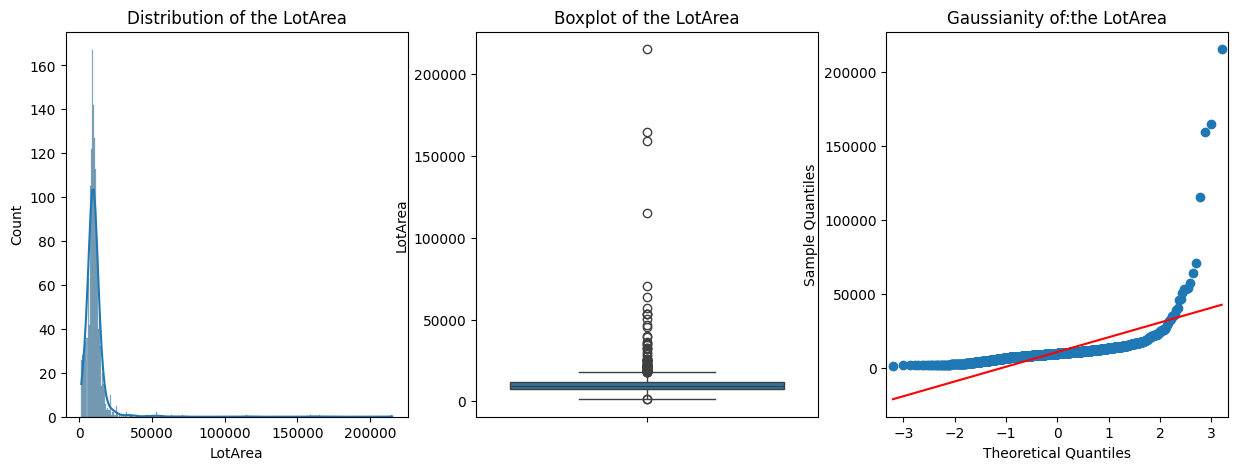

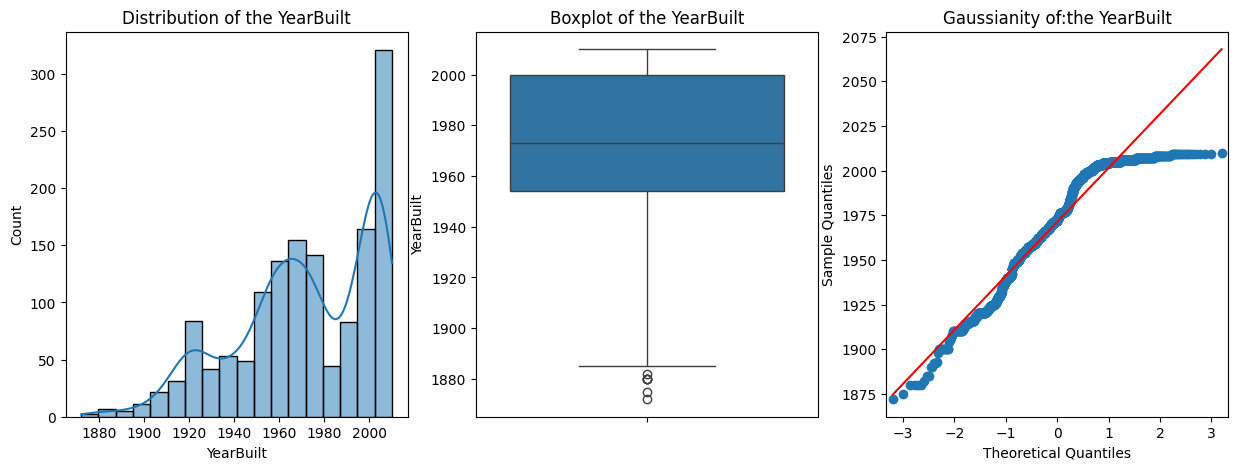

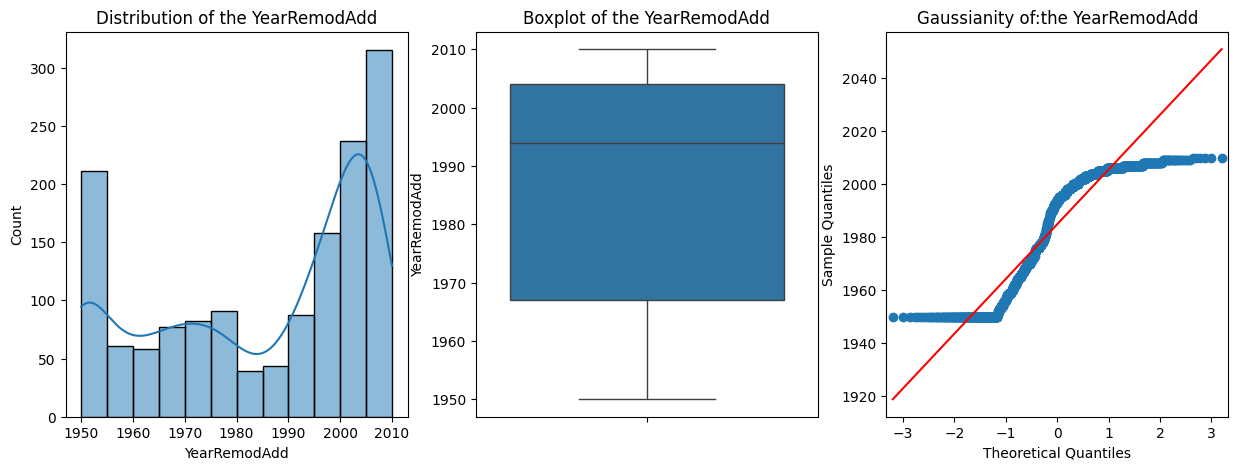

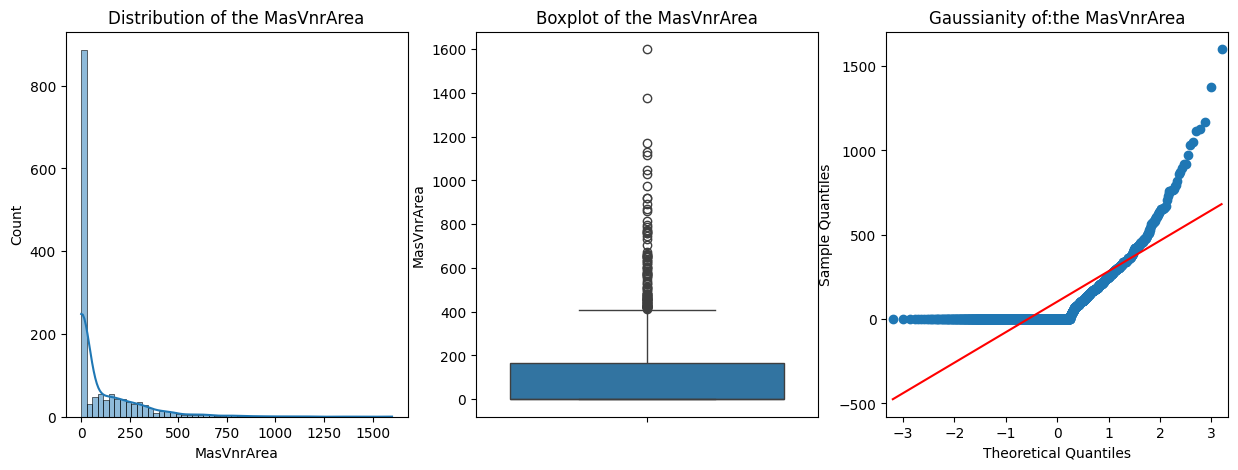

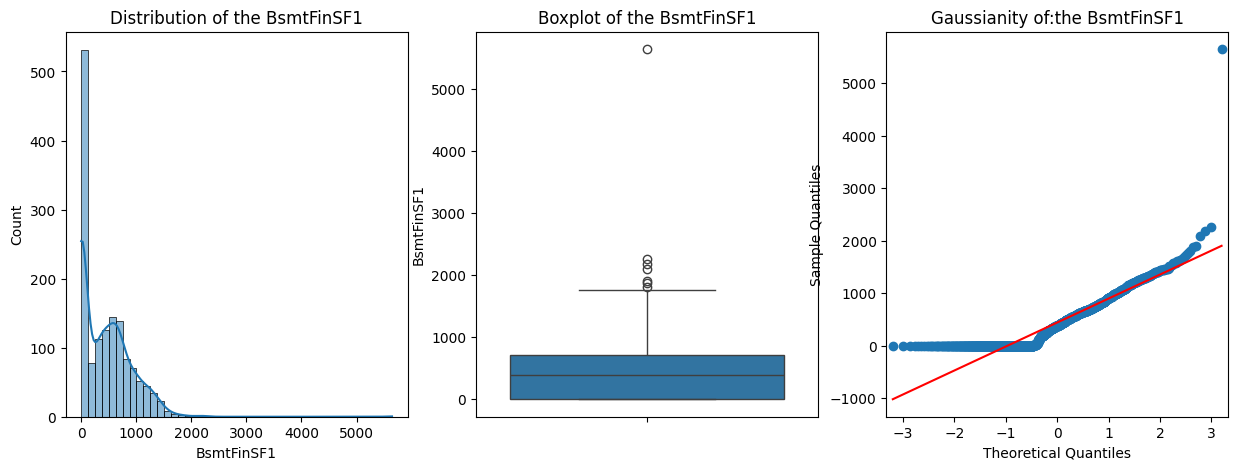

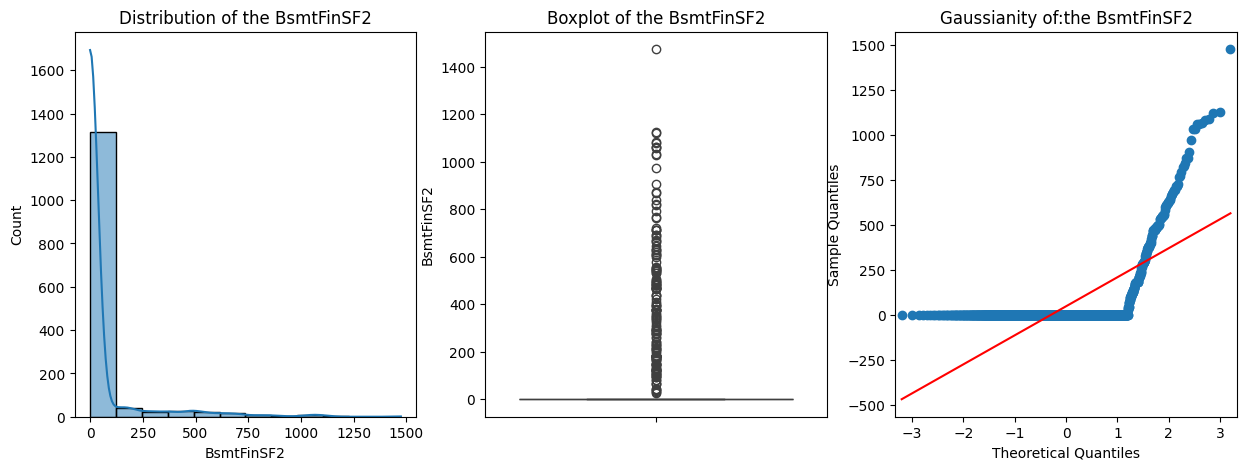

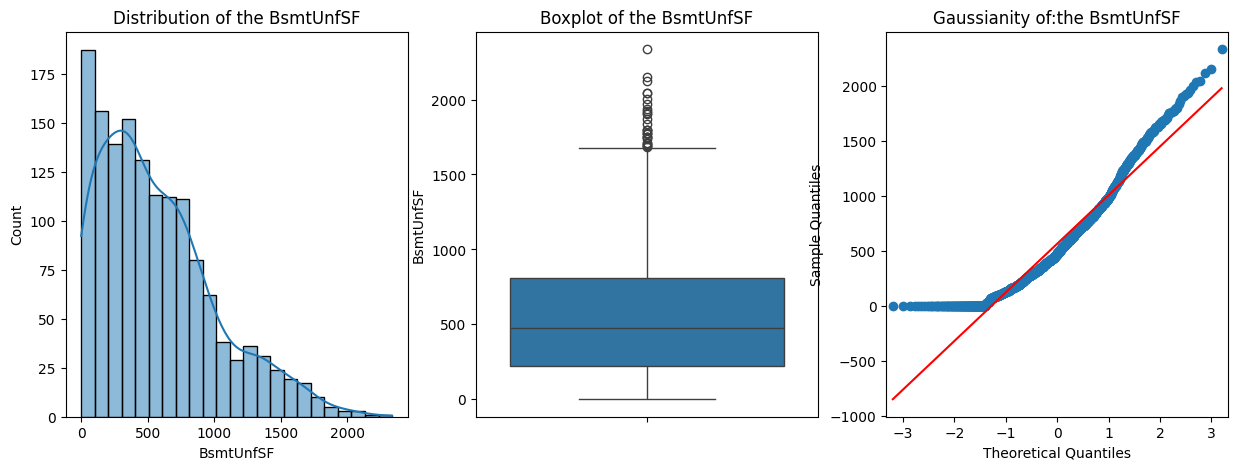

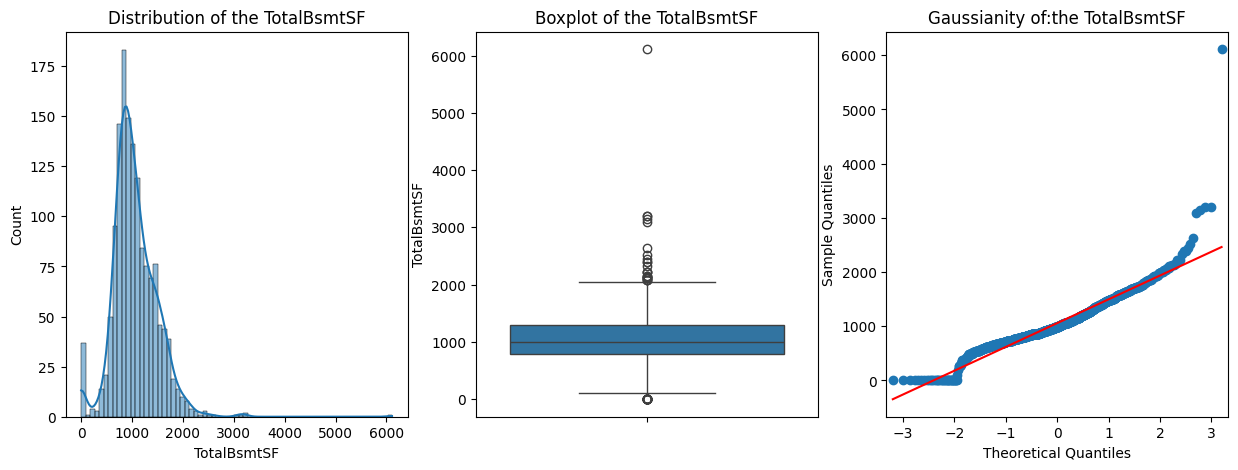

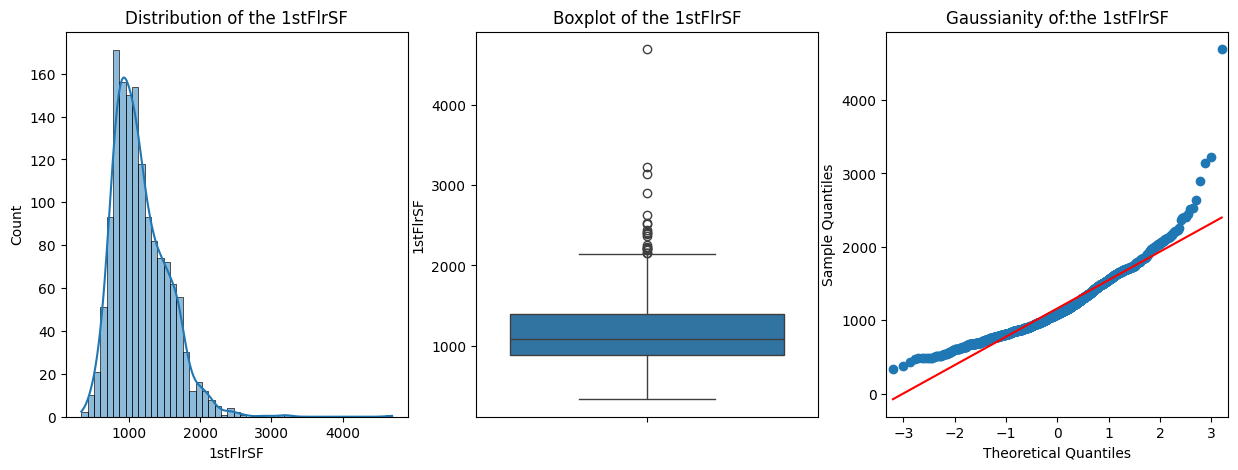

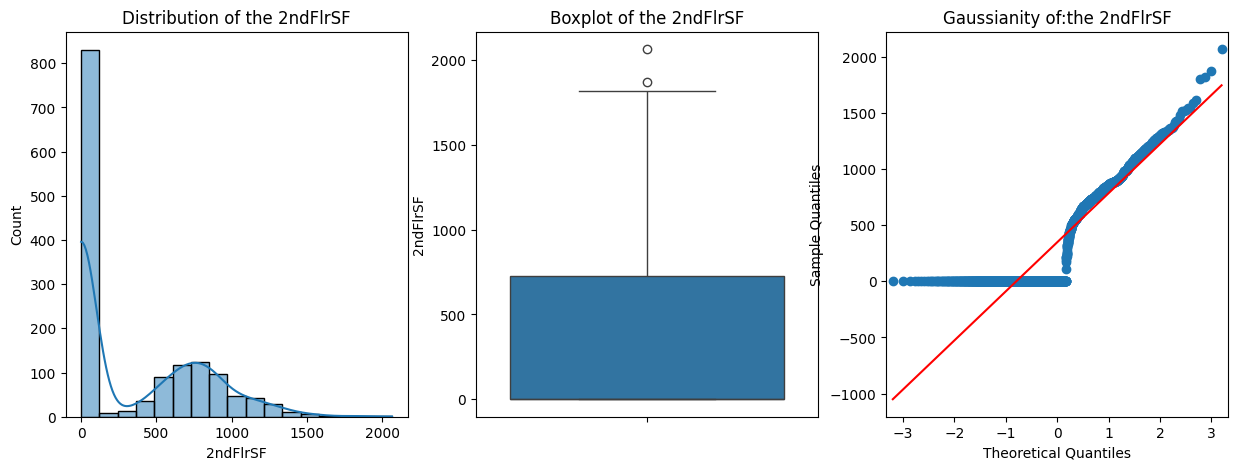

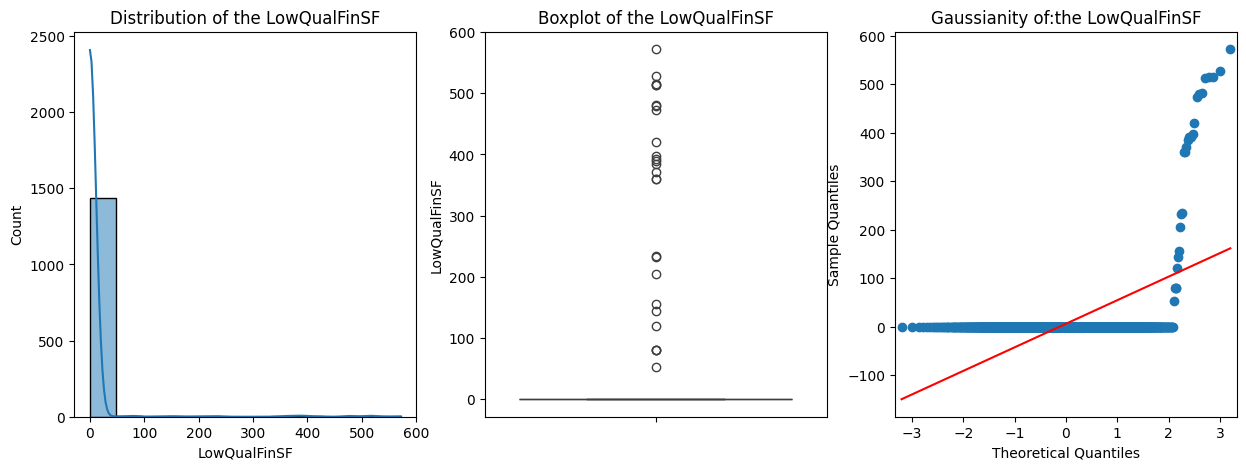

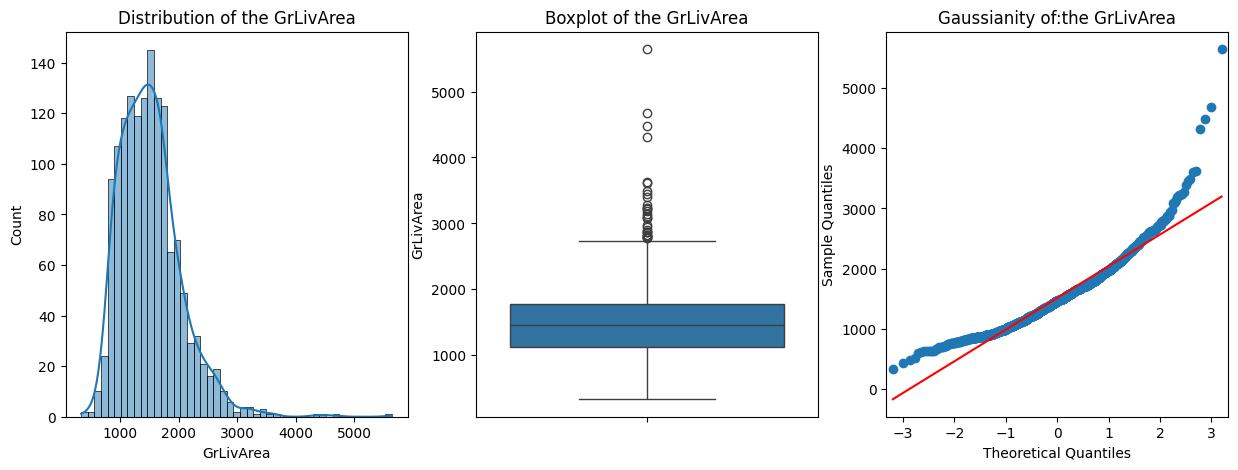

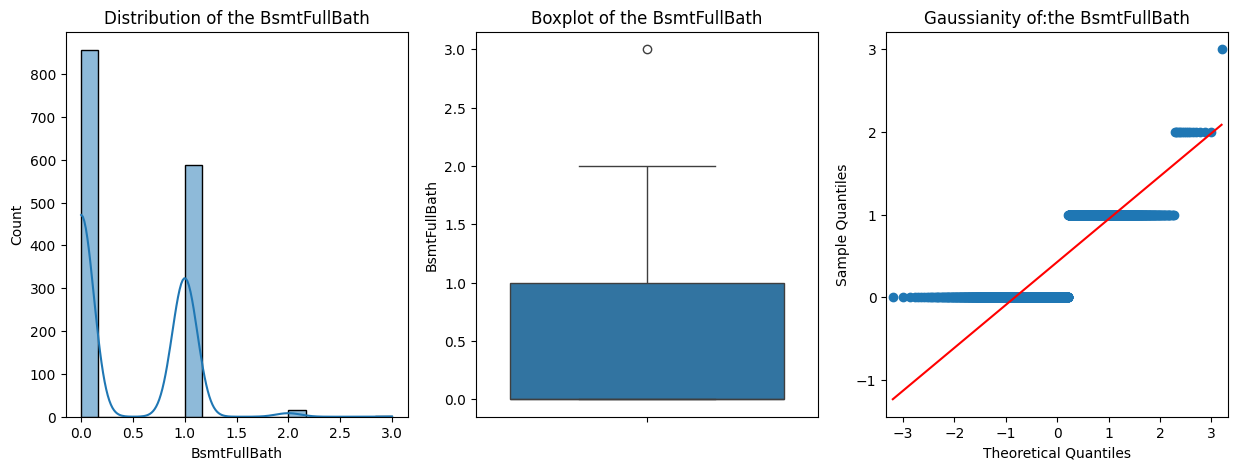

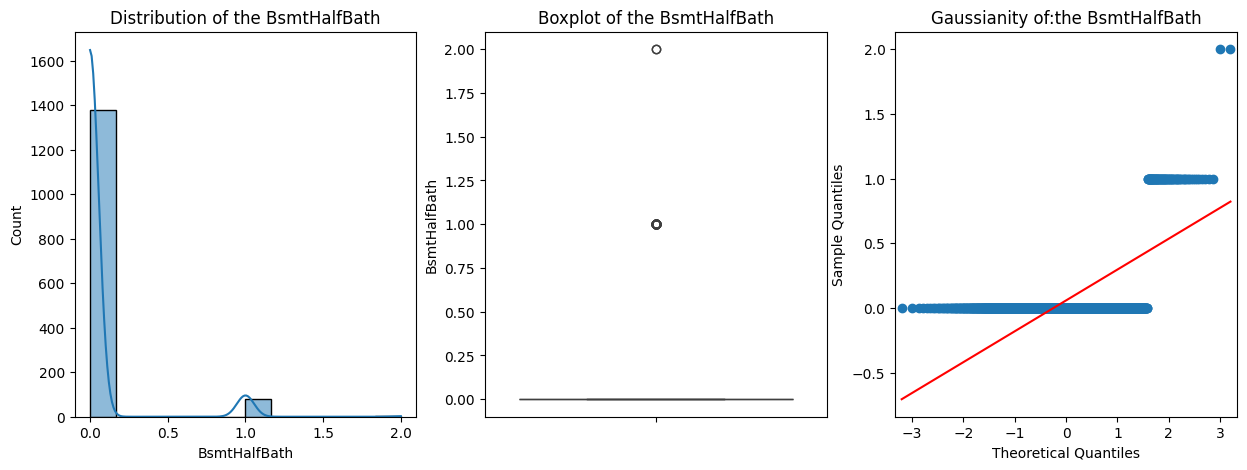

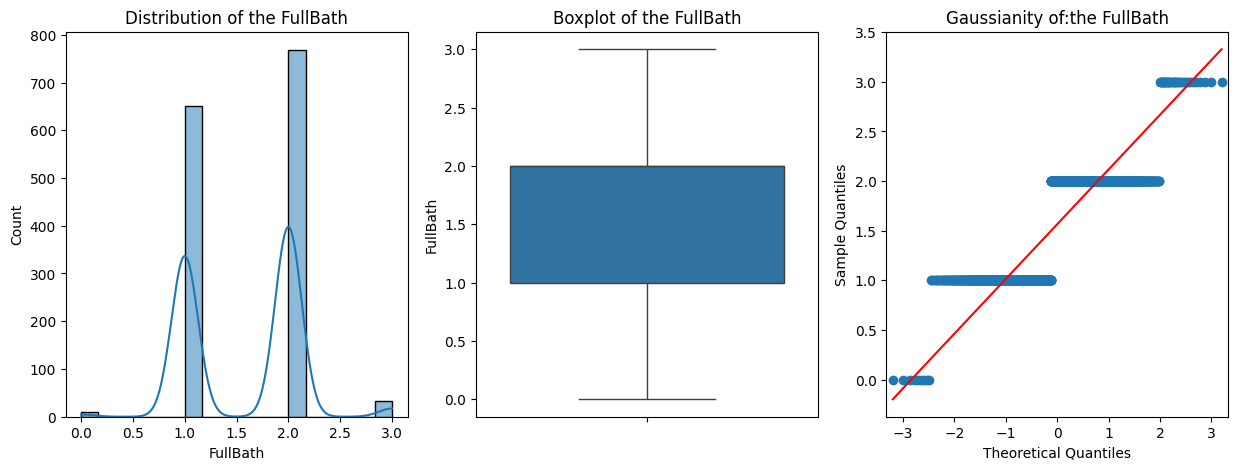

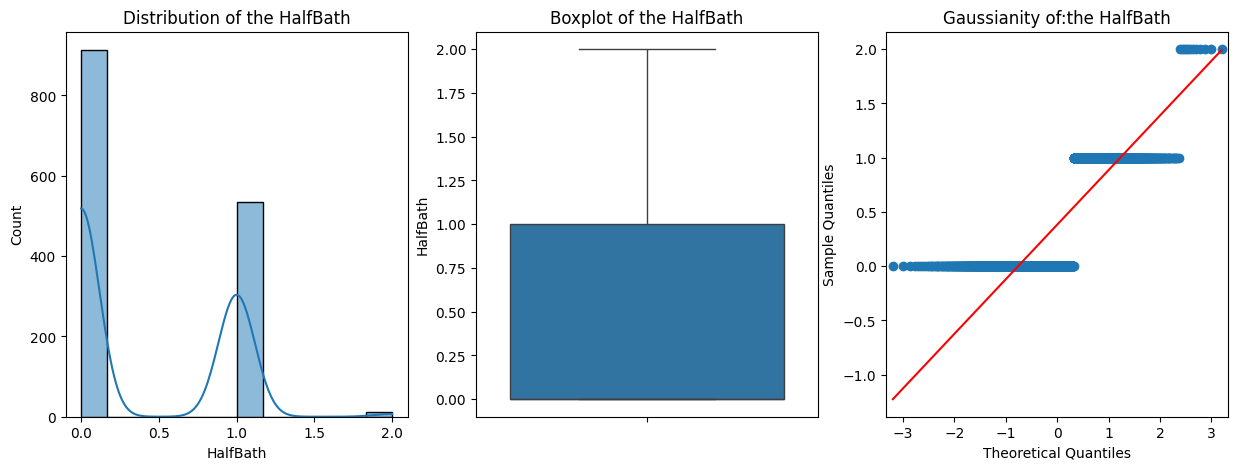

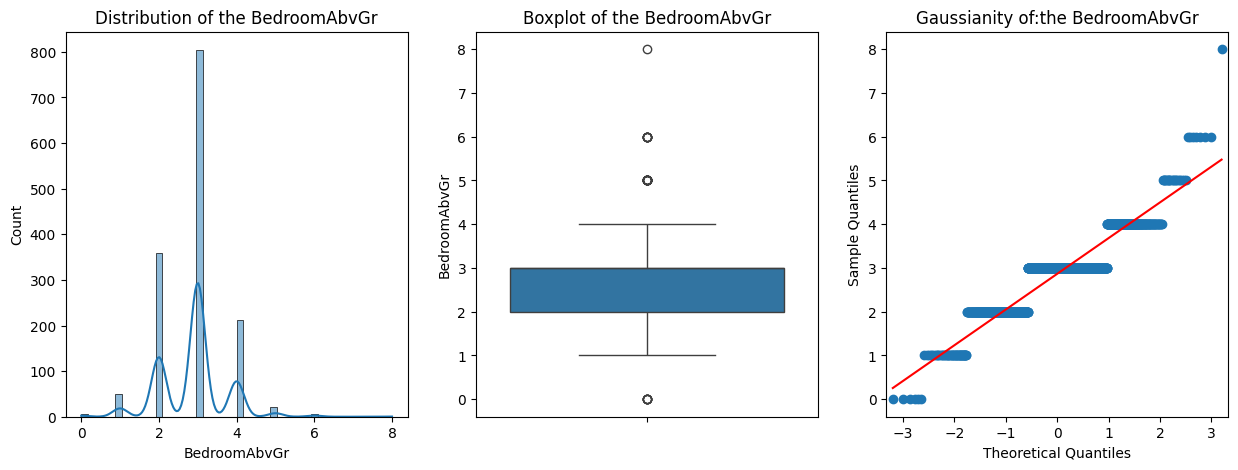

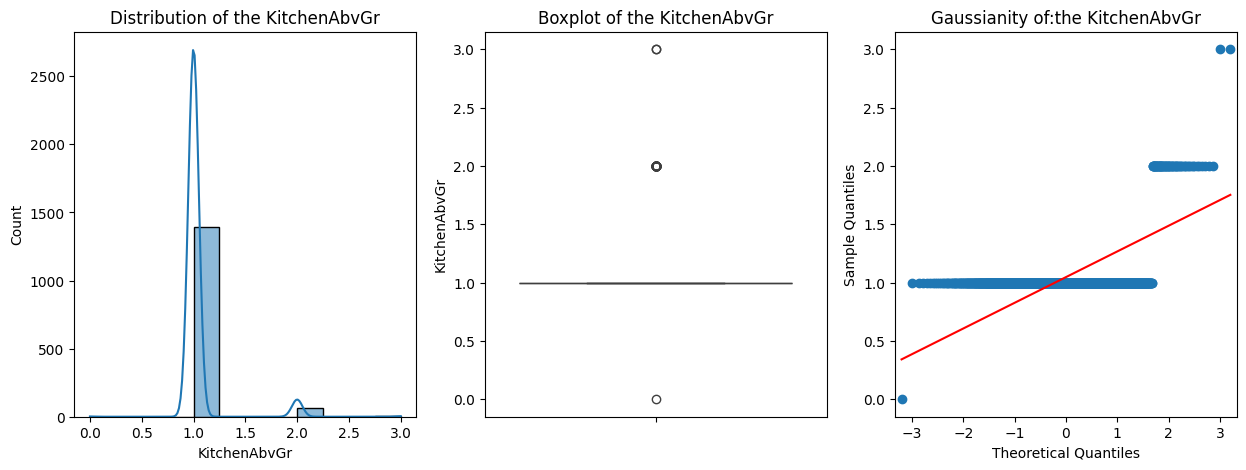

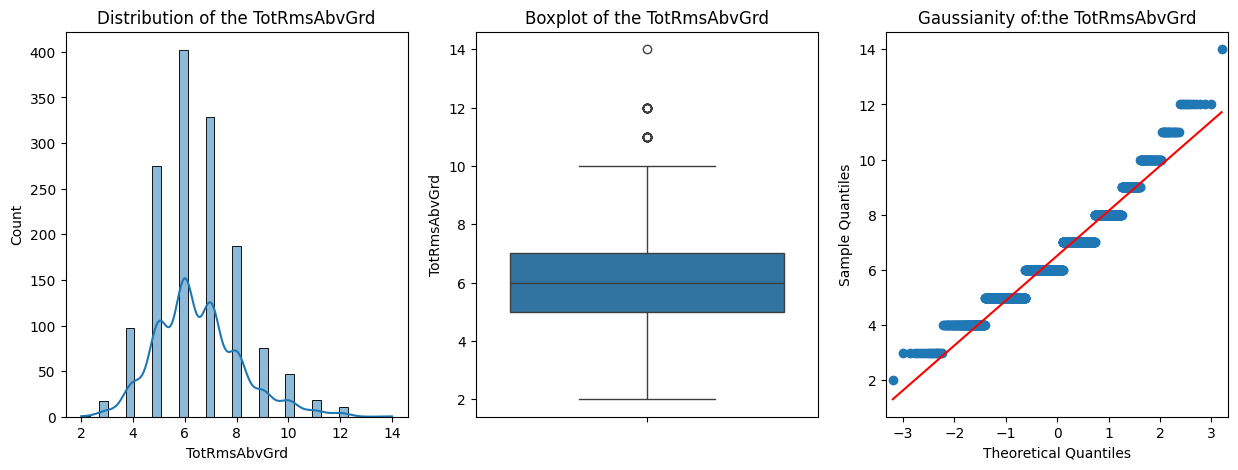

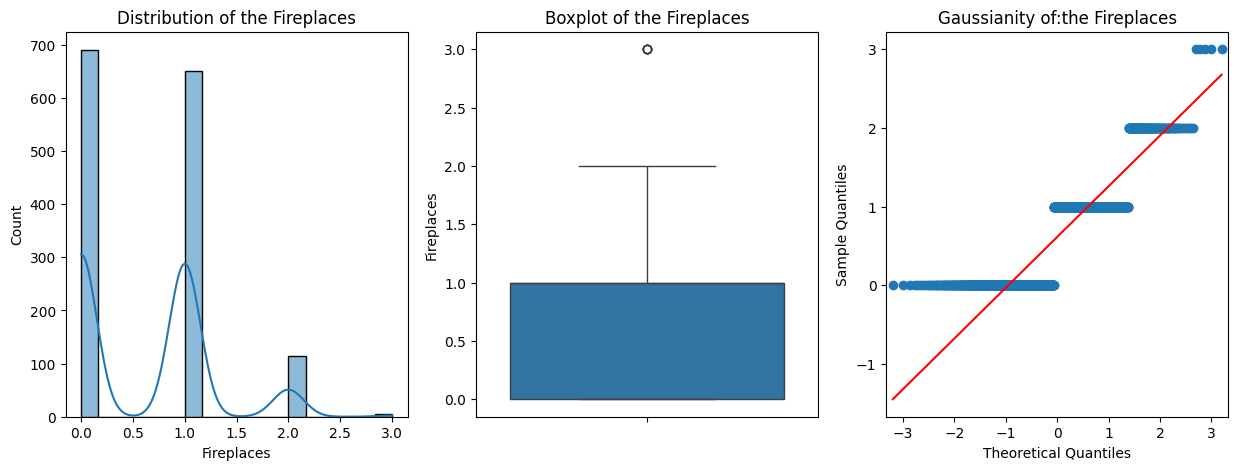

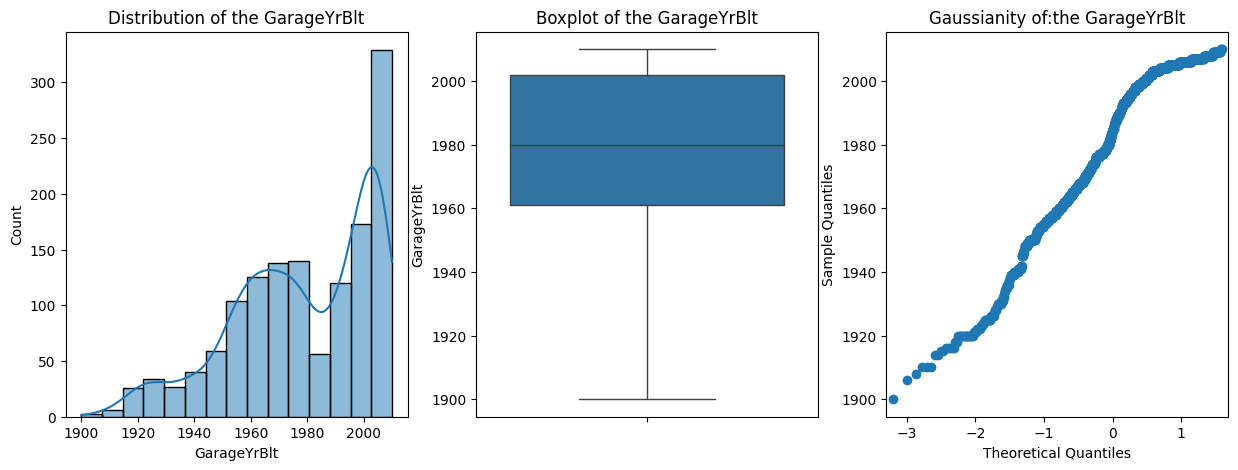

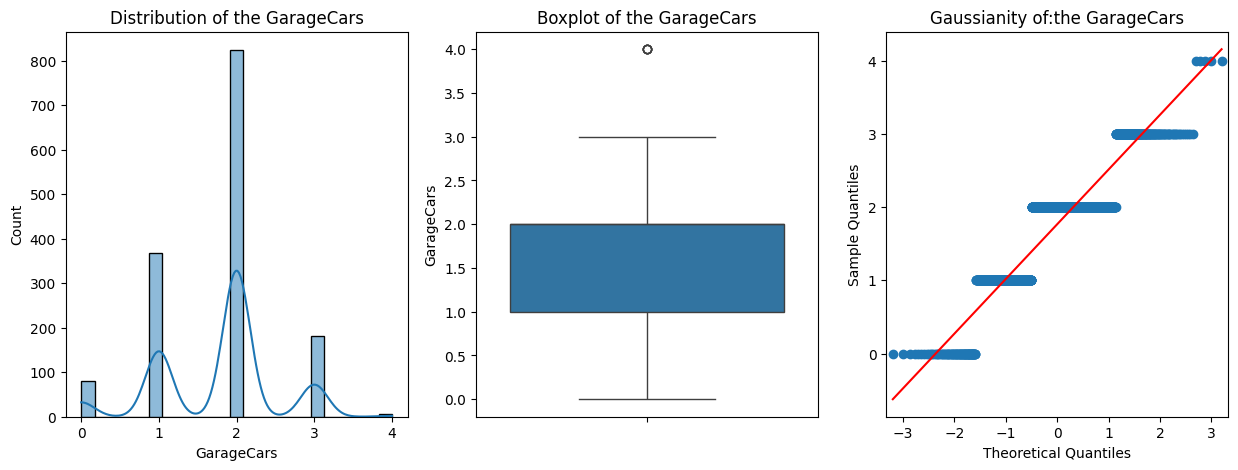

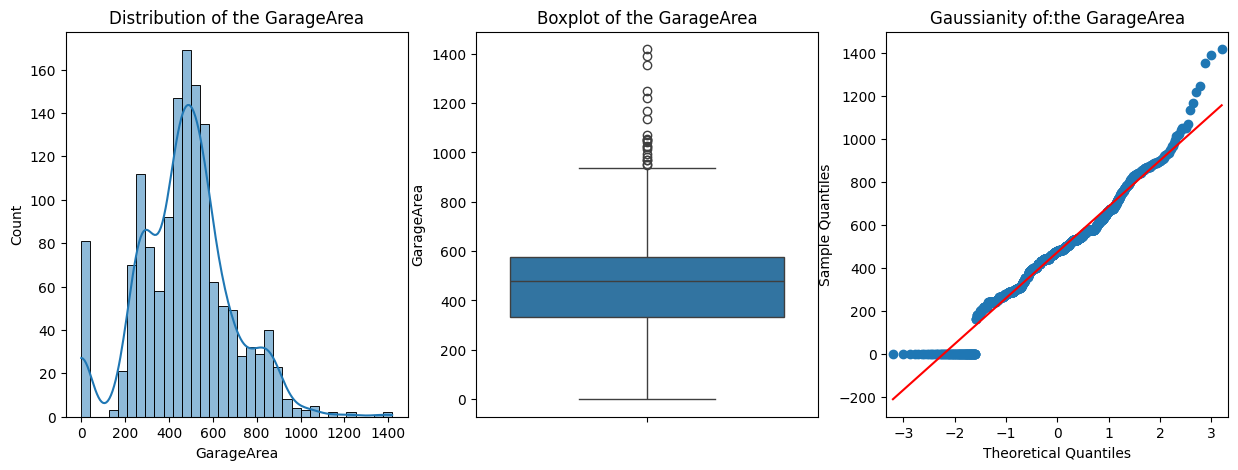

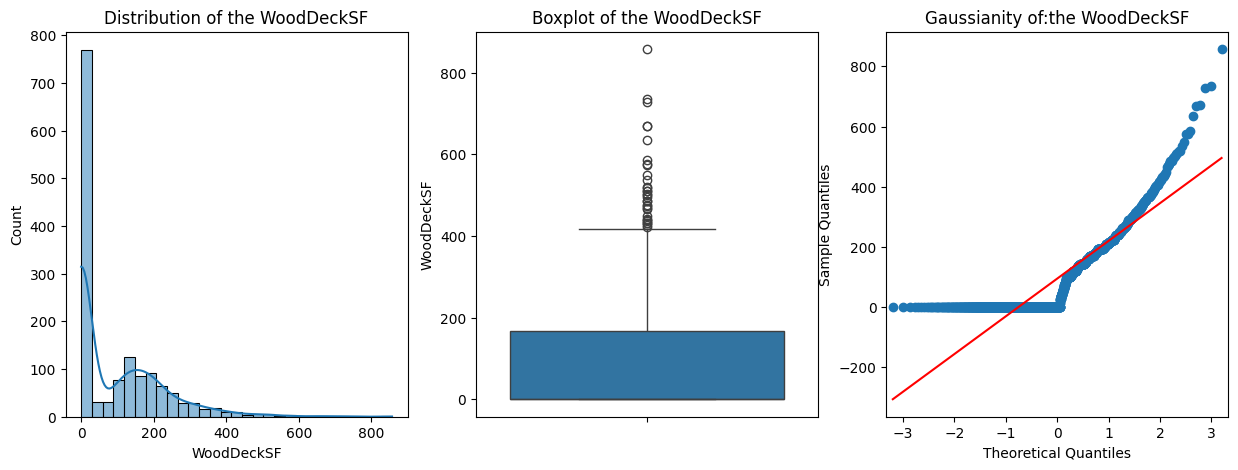

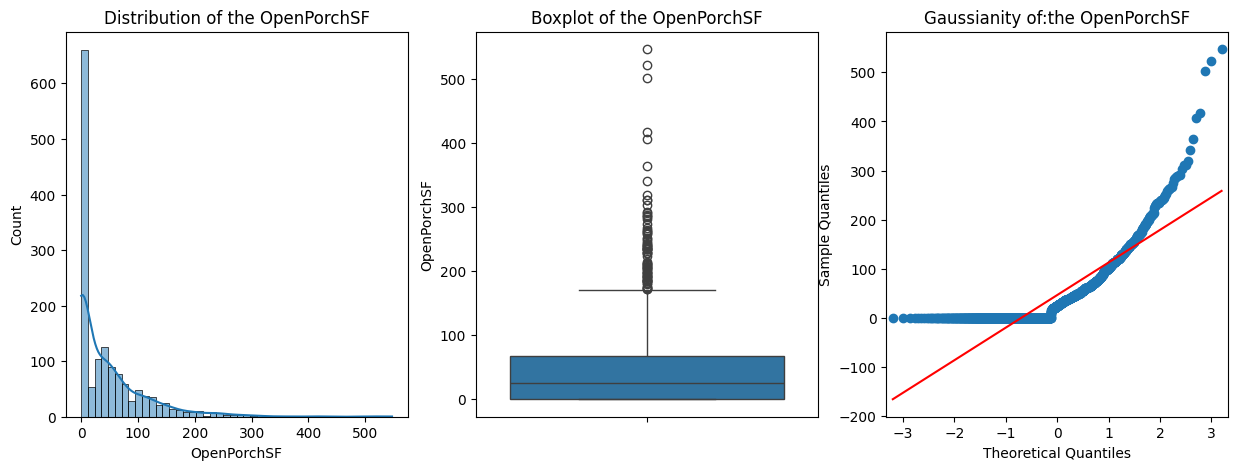

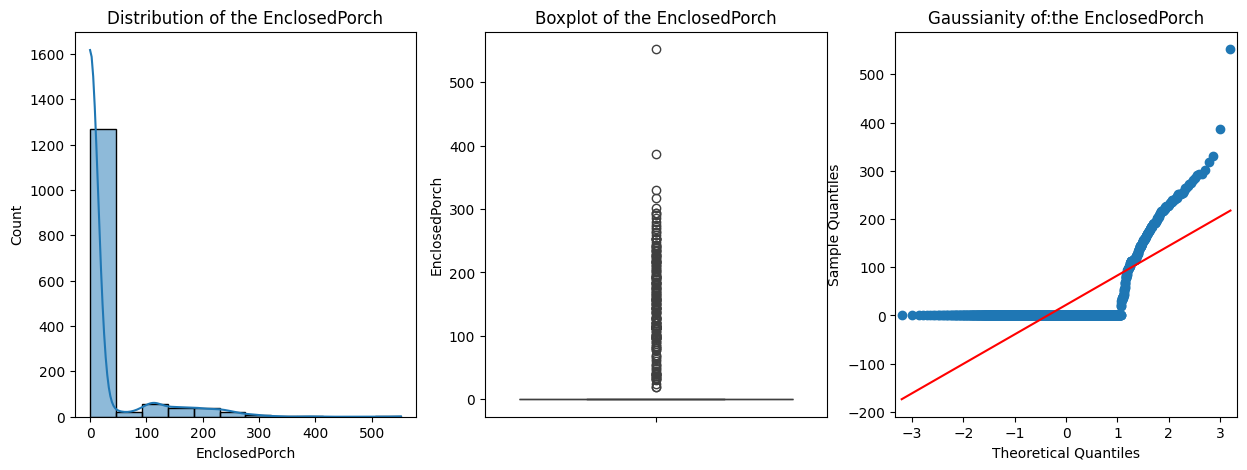

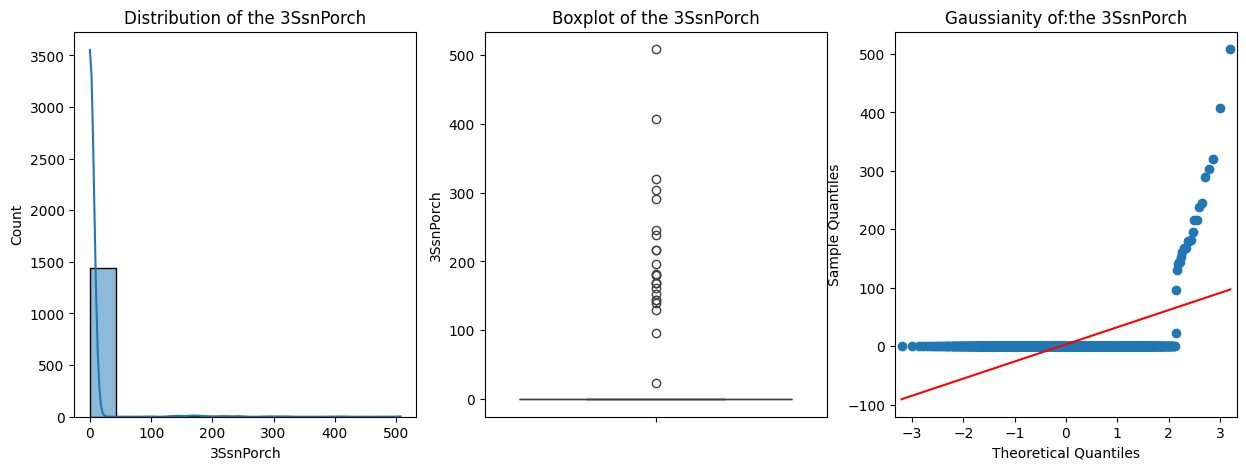

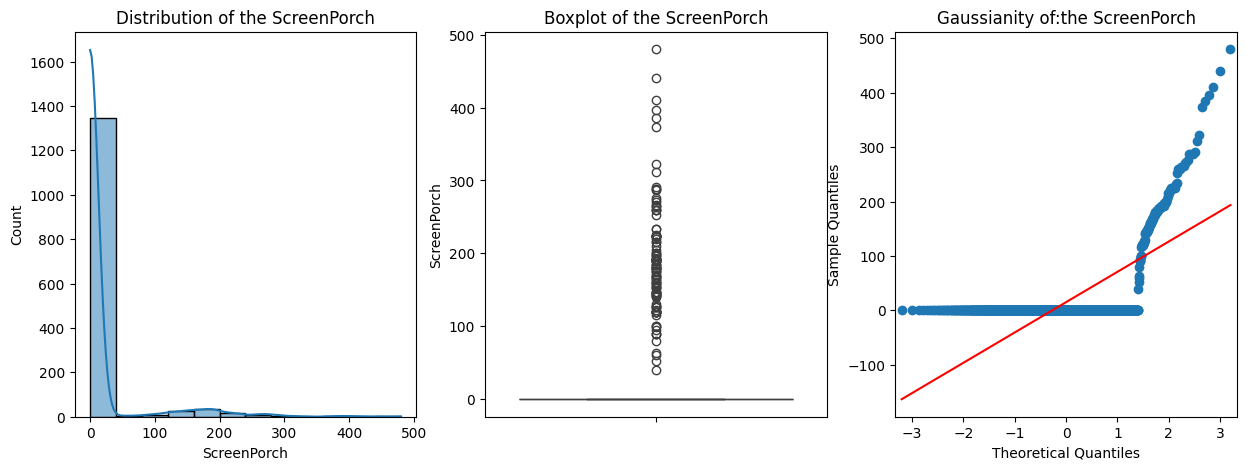

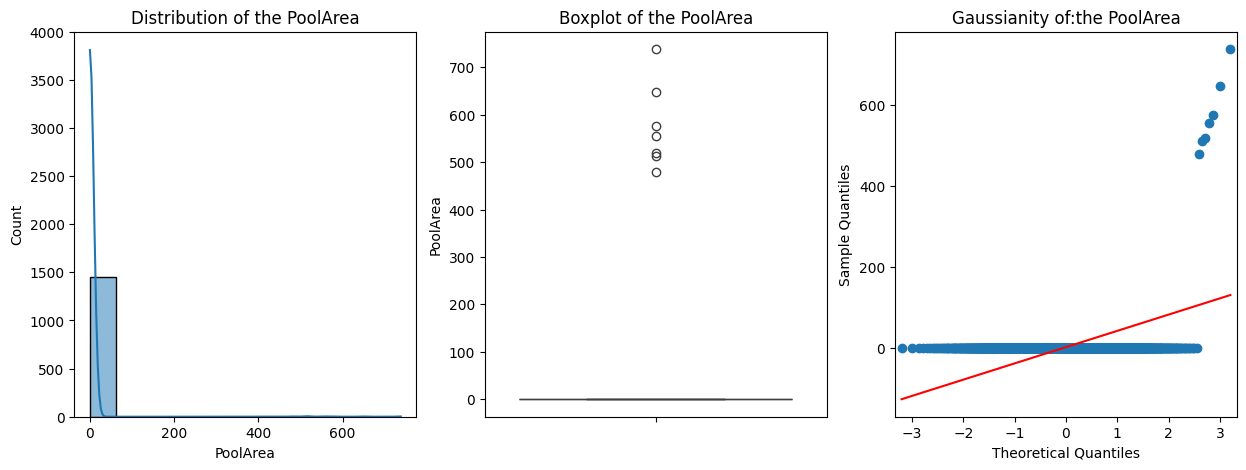

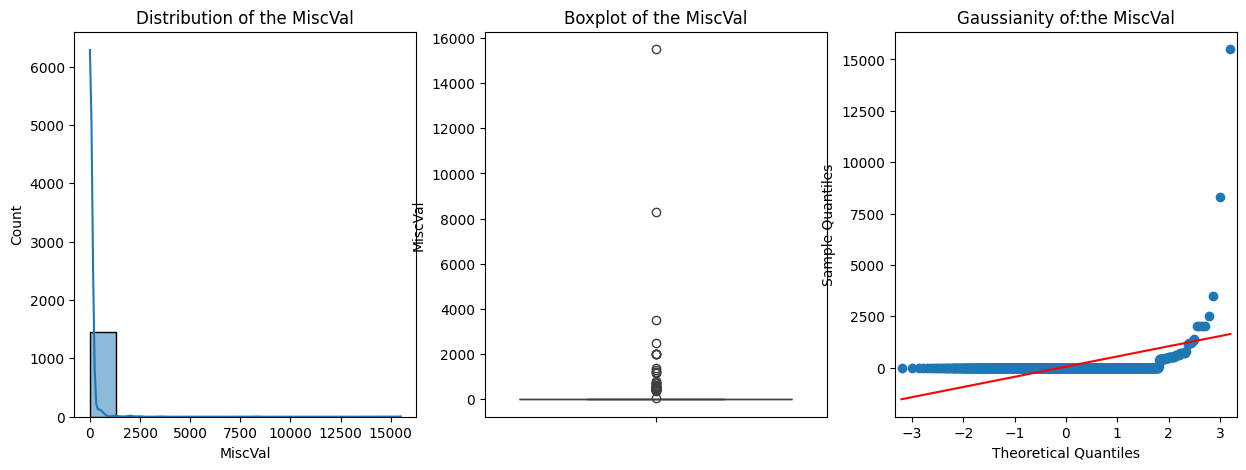

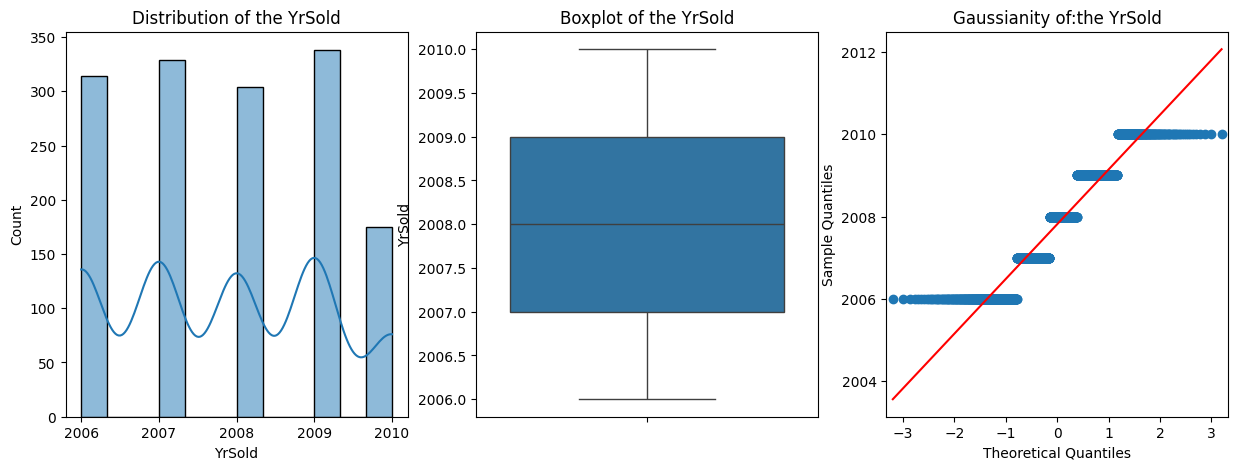

In [67]:
for feature in num_features:
    variable = feature

    fig, ax = plt.subplots(1,3,figsize=(15,5))
    
    ax[0].set_title(f"Distribution of the {variable}")
    sns.histplot(data = data[f"{variable}"], kde=True, ax = ax[0])
    
    ax[1].set_title(f"Boxplot of the {variable}")
    sns.boxplot(data = data[f"{variable}"], ax=ax[1])
    
    ax[2].set_title(f"Gaussianity of:the {variable}")
    qqplot(data[f"{variable}"],line='s',ax=ax[2]);

In [68]:
MM_features = ['YearRemodAdd', 'BsmtFullBath', 'FullBath', 'HalfBath', 'Fireplaces', 'GarageYrBlt', 'YrSold']
STD_features = []
RB_features = ['LotFrontage',
               'LotArea', 'YearBuilt',
               'MasVnrArea', 'BsmtFinSF1',
               'BsmtFinSF2', 'BsmtUnfSF',
               'TotalBsmtSF', '1stFlrSF',
               '2ndFlrSF', 'LowQualFinSF',
               'GrLivArea', 'BsmtHalfBath', 
               'BedroomAbvGr', 'KitchenAbvGr',
               'TotRmsAbvGrd', 'GarageCars', 
               'GarageArea', 'WoodDeckSF', 
               'OpenPorchSF', 'EnclosedPorch', 
               '3SsnPorch', 'ScreenPorch', 
               'PoolArea', 'MiscVal']

In [69]:
num_scaler = make_column_transformer(
    (MinMaxScaler(), MM_features),
    (RobustScaler(), RB_features))
num_scaler

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['YearRemodAdd', 'BsmtFullBath', 'FullBath',
                                  'HalfBath', 'Fireplaces', 'GarageYrBlt',
                                  'YrSold']),
                                ('robustscaler', RobustScaler(),
                                 ['LotFrontage', 'LotArea', 'YearBuilt',
                                  'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
                                  '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                                  'BsmtHalfBath', 'BedroomAbvGr',
                                  'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageCars',
                                  'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                                  'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                                  'PoolArea', 'MiscVal'])])

### Encoding categorical features

In [70]:
X_cat

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass,OverallQual,OverallCond
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal,60,7,5
2,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal,20,6,8
3,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal,60,7,5
4,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml,70,7,5
5,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal,60,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal,60,6,5
1457,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,None,MnPrv,None,WD,Normal,20,6,6
1458,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,None,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,None,GdPrv,Shed,WD,Normal,70,7,9


In [71]:
OHE = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition', 'Fence'] 
OE = ['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC']

In [72]:
OE_categories = [['Reg', 'IR1', 'IR2', 'IR3'], ['Gtl', 'Mod', 'Sev'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                ['Po', 'Fa', 'TA', 'Gd', 'Ex'],['Po', 'Fa', 'TA', 'Gd', 'Ex'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['None', 'No', 'Mn', 'Av', 'Gd'],
                ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                ['None', 'Unf', 'RFn', 'Fin'], ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['None', 'Fa', 'TA', 'Gd', 'Ex']]   

In [73]:
len(OE)

16

In [74]:
len(OE_categories)

16

In [75]:
cat_encoder = make_column_transformer(
    (OrdinalEncoder(categories = OE_categories), OE),
    (OneHotEncoder(drop = 'if_binary', sparse_output = False, handle_unknown = 'ignore'), OHE)
)
cat_encoder

ColumnTransformer(transformers=[('ordinalencoder',
                                 OrdinalEncoder(categories=[['Reg', 'IR1',
                                                             'IR2', 'IR3'],
                                                            ['Gtl', 'Mod',
                                                             'Sev'],
                                                            ['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex'],
                                                            ['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex'],
                                                            ['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex'],
                                                            ['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex'],
                                                            ['None', 'Po', 'Fa',
                                                             'TA', 'Gd', 'Ex'],
                                                            ['None', 'Po', 'Fa',
                                                             'TA', 'Gd', 'Ex'],
                                                            ['None', 'No', 'Mn',
                                                             'Av', 'Gd'],
                                                            ['None', 'Unf',
                                                             'LwQ', 'R...
                                               sparse_output=False),
                                 ['MSSubClass', 'MSZoning', 'Street', 'Alley',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'Neighborhood', 'Condition1', 'Condition2',
                                  'BldgType', 'HouseStyle', 'RoofStyle',
                                  'RoofMatl', 'Exterior1st', 'Exterior2nd',
                                  'MasVnrType', 'Foundation', 'Heating',
                                  'CentralAir', 'Electrical', 'Functional',
                                  'GarageType', 'PavedDrive', 'MiscFeature',
                                  'SaleType', 'SaleCondition', 'Fence'])])

### Preprocessing pipeline (1st level)

In [76]:
preprocessor = make_column_transformer(
    (num_scaler, X_num.columns),
    (cat_encoder, X_cat.columns),
    remainder = 'passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('columntransformer-1',
                                 ColumnTransformer(transformers=[('minmaxscaler',
                                                                  MinMaxScaler(),
                                                                  ['YearRemodAdd',
                                                                   'BsmtFullBath',
                                                                   'FullBath',
                                                                   'HalfBath',
                                                                   'Fireplaces',
                                                                   'GarageYrBlt',
                                                                   'YrSold']),
                                                                 ('robustscaler',
                                                                  RobustScaler(),
                                                                  ['LotFrontage',
                                                                   'LotArea',
                                                                   'YearBuilt',
                                                                   'MasVnrArea',
                                                                   'BsmtFinSF1',
                                                                   'BsmtFinSF2',
                                                                   'BsmtUnfSF...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass', 'OverallQual',
       'OverallCond'],
      dtype='object'))])

In [77]:
X_preproc = preprocessor.fit_transform(X)
transformed_feature_names = preprocessor.get_feature_names_out(input_features=X.columns)
# Using AI tools to help clean the names after pipeline preprocessing
clean_features_names = []
for feature in transformed_feature_names:
    clean_feature_name = re.sub(r'^.*__(.+)$', r'\1', feature)
    clean_features_names.append(clean_feature_name)
X_preproc = pd.DataFrame(X_preproc, columns = clean_features_names )
X_preproc

,YearRemodAdd,BsmtFullBath,FullBath,HalfBath,Fireplaces,GarageYrBlt,YrSold,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtHalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,LotShape,LandSlope,ExterQual,ExterCond,HeatingQC,KitchenQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PavedDrive_N,PavedDrive_P,PavedDrive_Y,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,Garage,Bsmt,Pool,fence,sin_MoSold,cos_MoSold
0,0.883333,0.333333,0.666667,0.5,0.000000,0.936364,0.50,-0.210526,-0.254076,0.6521

### Feature selection + Full Preprocessing pipeline

In [78]:
# SelectPercentile does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values.

In [79]:
preproc_selector = SelectFromModel(RandomForestRegressor(), threshold = 'median')

preproc = make_pipeline(preprocessor, preproc_selector)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('columntransformer-1',
                                                  ColumnTransformer(transformers=[('minmaxscaler',
                                                                                   MinMaxScaler(),
                                                                                   ['YearRemodAdd',
                                                                                    'BsmtFullBath',
                                                                                    'FullBath',
                                                                                    'HalfBath',
                                                                                    'Fireplaces',
                                                                                    'GarageYrBlt',
                                                                                    'YrSold']),
                                                                                  ('robustscaler',
                                                                                   RobustScaler(),
                                                                                   ['LotFrontage',
                                                                                    'LotArea',
                                                                                    'YearBuilt',
                                                                                    'MasVnrArea'...
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass', 'OverallQual',
       'OverallCond'],
      dtype='object'))])),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestRegressor(),
                                 threshold='median'))])

In [80]:
X_selected = preproc.fit_transform(X, y)
selected_feature_indices = preproc.named_steps['selectfrommodel'].get_support(indices=True)
transformed_feature_names = preproc.named_steps['columntransformer'].get_feature_names_out()
selected_feature_names = [transformed_feature_names[i] for i in selected_feature_indices]

clean_features_names = []
for feature in selected_feature_names:
    clean_feature_name = re.sub(r'^.*__(.+)$', r'\1', feature)
    clean_features_names.append(clean_feature_name)

X_final = pd.DataFrame(X_selected, columns = clean_features_names)
X_final

,YearRemodAdd,BsmtFullBath,FullBath,HalfBath,Fireplaces,GarageYrBlt,YrSold,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtHalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,LotShape,LandSlope,ExterQual,ExterCond,HeatingQC,KitchenQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageFinish,GarageQual,GarageCond,MSSubClass_20,MSSubClass_30,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_120,MSZoning_C (all),MSZoning_RL,MSZoning_RM,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Somerst,Neighborhood_StoneBr,Condition1_Feedr,Condition1_Norm,Condition1_PosN,Condition2_Norm,Condition2_PosN,BldgType_1Fam,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofMatl_CompShg,Exterior1st_BrkFace,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,CentralAir_Y,Functional_Typ,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,PavedDrive_N,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Fence_GdPrv,Fence_None,fence,sin_MoSold,cos_MoSold
0,0.883333,0.333333,0.666667,0.5,0.000000,0.936364,0.50,-0.210526,-0.254076,0.652174,1.193303,0.452790,0.0,-0.559829,-0.269652,-0.453608,1.173077,0.0,0.380070,0.0,0.0,0.0,1.0,0.0,0.281573,0.000000,0.529412,0.0,0.0,0.0,0.0,0.0,3.0,2.0,4.0,3.0,4.0,3.0,1.0,6.0,1.0,0.0,2.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.500000,8.660254e-01
1,0.433333,0.000000,0.666667,0.0,0.333333,0.690909,0.25,0.578947,0.030015,0.065217,0.000000,0.834679,0.0,-0.330769,0.538308,0.343643,0.000000,0.0,-0.312090,1.0,0.0,0.0,0.0,0.0,-0.082816,1.773810,-0.367647,0.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0,2.0,4.0,3.0,4.0,5.0,1.0,3.0,2.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.866025,-5.000000e-01
2,0.866667,0.333333,0.666667,0.5,0.333333,0.918182,0.50,-0.052632,0.437624,0.608696,0.986301,0.143910,0.0,-0.074359,-0.142289,-0.327933,1.189560,0.0,0.497489,0.0,0.0,0.0,0.0,0.0,0.530021,0.000000,0.250000,0.0,0.0,0.0,1.0,0.0,3.0,2.0,4.0,3.0,4.0,3.0,2.0,6.0,1.0,3.0,2.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.866025,-5.000000e-01
3,0.333333,0.333333,0.333333,0.0,0.333333,0.890909,0.00,-0.473684,0.017663,-1.260870,0.000000,-0.235170,0.0,0.106838,-0.468657,-0.247423,1.038462,0.0,0.390885,0.0,0.0,0.0,0.5,1.0,0.670807,0.000000,0.147059,272.0,0.0,0.0,1.0,0.0,2.0,2.0,3.0,3.0,3.0,4.0,1.0,5.0,1.0,4.0,

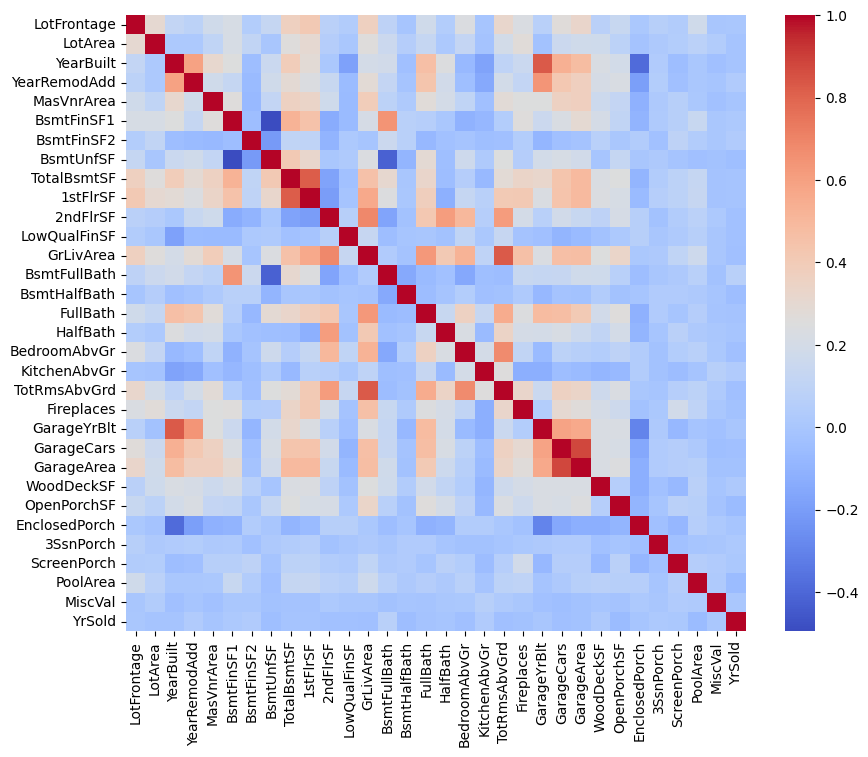

In [81]:
# Correlation of X_num (just to view)
corr_num = X_num.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr_num, cmap ='coolwarm');

### Target Engineering

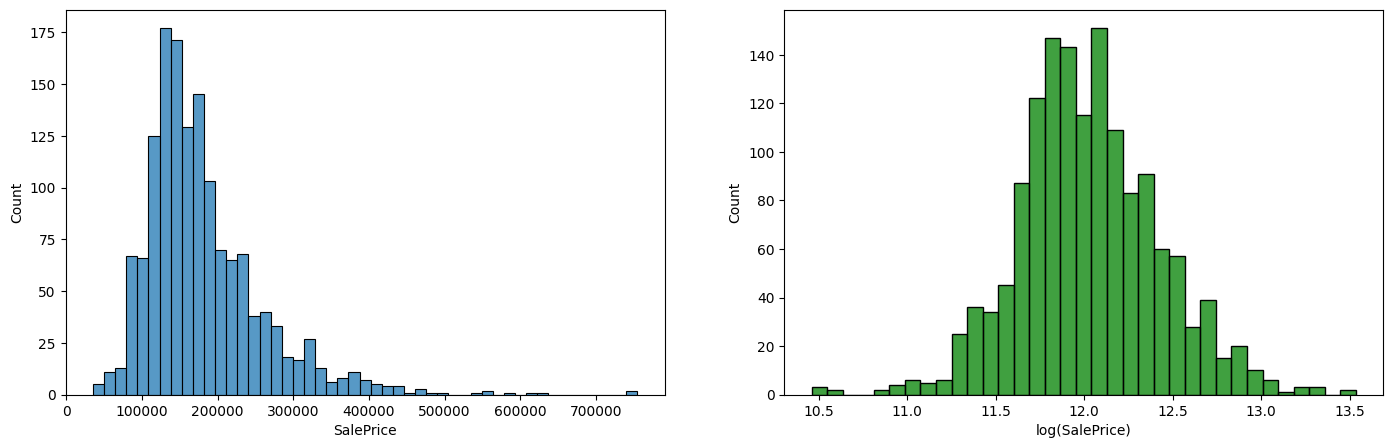

In [82]:
# Transforming target to directly predict its log
y_log = np.log(y)
plt.figure(figsize = (17, 5))

plt.subplot(1, 2, 1)
sns.histplot(y)

plt.subplot(1, 2, 2)
sns.histplot(y_log, color = 'g')
plt.xlabel('log(SalePrice)');

## Custom Scorer (RMSE)

In [83]:
# new scorers
RMSE = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5)
neg_RMSE = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5)

# Modelling

In [84]:
allow_grid_searching = True


In [85]:
# Normally i would add estmiators at the end of the piepline but in this case,
#As we have some models that won't accept NaN vlaues we need to define X with NaN and one without
nan_indices = X_final[X_final['GarageYrBlt'].isna()].index

X_dropped = X_final.drop(nan_indices)
y_dropped = y_log.drop(nan_indices)

X_full = X_final
y_full = y_log

In [86]:
# Baseline score, to beat :) 
bs_cv_score

0.21025767665032294

## Linear models

### Linear Regression

In [87]:
linreg = LinearRegression()
linreg_score = cross_val_score(linreg, X_dropped, y_dropped, cv = 10, scoring = RMSE).mean()
linreg_score

0.22079417433756396

### Ridge

In [88]:
ridge = Ridge()
ridge_score = cross_val_score(ridge, X_dropped, y_dropped, cv = 10, scoring = RMSE).mean()
ridge_score

0.22062462863595766

In [89]:
if allow_grid_searching:
    param_grid = {'alpha' : np.linspace(0.01, 3, num = 20)}

    search_ridge = GridSearchCV(
        estimator = ridge,
        param_grid = param_grid,
        cv = 10, 
        n_jobs = -1,
        verbose = 2,
        scoring = neg_RMSE
    )
    search_ridge.fit(X_dropped, y_dropped)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [90]:
search_ridge.best_params_

{'alpha': 3.0}

In [91]:
search_ridge.best_score_

0.22127078453743693

### ElasticNet

In [92]:
elasticnet = ElasticNet()
elasticnet_score = cross_val_score(elasticnet, X_dropped, y_dropped, cv = 5, n_jobs = -1, scoring = RMSE).mean()
elasticnet_score

0.3940907278848898

## KNN

In [93]:
knn = KNeighborsRegressor()
cross_val_score(knn, X_dropped, y_dropped, cv = 10, scoring = RMSE).mean()

0.2870607909179239

In [94]:
if allow_grid_searching:
    param_grid = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]}
    search_knn = GridSearchCV(
        knn,
        param_grid,
        cv = 3, 
        n_jobs = -1,
        verbose = 2, 
        scoring = neg_RMSE
    )
    search_knn.fit(X_dropped, y_dropped)
    

Fitting 3 folds for each of 11 candidates, totalling 33 fits


In [95]:
search_knn.best_params_

{'n_neighbors': 3}

In [96]:
search_knn.best_score_

0.29875409533656744

## SVR

In [97]:
# model below takes much time, results poor

In [98]:
#%%time
#svr_lin = SVR(kernel = 'linear')
#svr_lin_score = cross_val_score(svr_lin, X_dropped, y_dropped, cv = 5, scoring = RMSE, n_jobs = -1, verbose = 0).mean()
#svr_lin_score

In [99]:
%%time
svr_rbf = SVR(kernel = 'rbf', C = 10)
svr_rbf_score = cross_val_score(svr_rbf, X_dropped, y_dropped, cv = 10, scoring = RMSE, n_jobs = -1, verbose = 1).mean()
svr_rbf_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


CPU times: user 8 ms, sys: 2.43 ms, total: 10.4 ms
Wall time: 267 ms


0.2551936656397518

## Trees

In [100]:
tree = DecisionTreeRegressor()
tree_score = cross_val_score(tree, X_full, y_full, cv = 5, scoring = RMSE, n_jobs = -1).mean()
tree_score

0.21764691185252757

## Random Forest

### Dropped data

In [101]:
rforest = RandomForestRegressor()
d_rforest_cv_scores = cross_val_score(rforest, X_dropped, y_dropped, cv = 10, scoring = RMSE, n_jobs = -1)
d_rforest_score = d_rforest_cv_scores.mean()
d_rforest_std = d_rforest_cv_scores.std()
print(d_rforest_score)
print(d_rforest_std)

0.22689511621830066
0.034904966288576415


### Full data

In [102]:
%%time
rforest = RandomForestRegressor(max_depth= 4, min_samples_split = 3, n_estimators = 70)
rforest_cv_scores = cross_val_score(rforest, X_full, y_full, cv = 10, scoring = RMSE, n_jobs = -1)
rforest_score = rforest_cv_scores.mean()
rforest_std = rforest_cv_scores.std()
print(rforest_score)
print(rforest_std)

0.18075823491184237
0.019216731534337658
CPU times: user 11.5 ms, sys: 3.85 ms, total: 15.3 ms
Wall time: 809 ms


In [103]:
if allow_grid_searching:
    param_grid = { 
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [50, 75, 100]
    }
    search_rforest = GridSearchCV(
        rforest,
        param_grid,
        cv = 10,
        n_jobs = -1,
        verbose = 0,
        scoring = neg_RMSE
    )
    search_rforest.fit(X_full, y_full);

In [104]:
search_rforest.best_params_

{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}

In [105]:
search_rforest.best_score_

0.2051083836367375

## Boosted Trees

### Ada Boost Regressor

In [106]:
# %%time
# adaboost = AdaBoostRegressor(estimator = RandomForestRegressor())
# adaboost_score = cross_val_score(adaboost, X_dropped, y_dropped, cv = 10 ,scoring = RMSE).mean()
# adaboost_score

### Gradient Boost Regressor

In [107]:
%%time
gradientboost = GradientBoostingRegressor()
gradientboost_score = cross_val_score(gradientboost, X_dropped, y_dropped, cv = 10 ,scoring = RMSE).mean()
gradientboost_score

CPU times: user 4.15 s, sys: 3.61 ms, total: 4.15 s
Wall time: 4.18 s


0.21883501145157297

### Hist Gradient Boost Regressor

In [108]:
%%time
# Chosen these hyperparameters
hgbr = HistGradientBoostingRegressor(learning_rate = 0.05, max_iter = 60, min_samples_leaf = 3, max_depth = 3)
hgbr_cv_scores = cross_val_score(hgbr, X_full, y_full, cv = 5, scoring = RMSE)
hgbr_score = hgbr_cv_scores.mean()
hgbr_std = hgbr_cv_scores.std()
print(hgbr_score)
print(hgbr_std)

0.15544292923723285
0.009988942357958686
CPU times: user 2.34 s, sys: 586 ms, total: 2.92 s
Wall time: 387 ms


## XGBoost

In [109]:
xgb = XGBRegressor(eval_metric = RMSE, learning_rate = 0.1, max_depth = 2, n_estimators = 35, min_child_weight=2, gamma=0.05, reg_alpha=0.01, 
    reg_lambda=0.01)
xgb_cv_scores = cross_val_score(xgb, X_full, y_full, cv = 5, scoring = RMSE, n_jobs = -1)
xgb_score = xgb_cv_scores.mean()
xgb_std = xgb_cv_scores.std()
print(xgb_score)
print(xgb_std)

0.16339662568969354
0.010008073921622845


In [110]:
if allow_grid_searching:
    param_grid = {
        'n_estimators': [25, 30, 45, 65], 
        'learning_rate': [0.08, 0.05, 0.1],  
        'max_depth': [1, 2, 3, 4]
    }
    xgb_search = GridSearchCV(
        xgb,
        param_grid, 
        cv = 10,
        n_jobs = -1,
        verbose = 0,
        scoring = neg_RMSE
    )
    xgb_search.fit(X_full, y_full)

In [111]:
xgb_search.best_params_

{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 25}

In [112]:
xgb_search.best_score_

0.2801842396629953

# Model Selection 

## Best models inspection

### Learning Curve

#### Trees

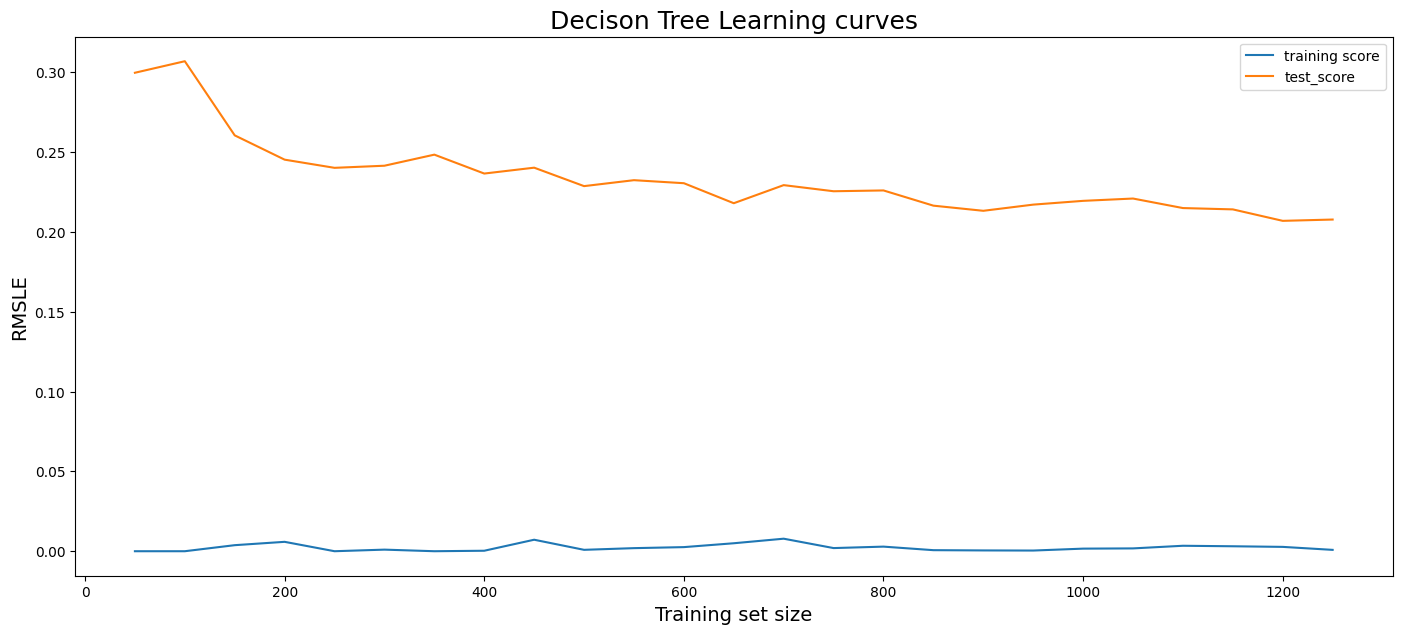

In [113]:
train_sizes = np.arange(50, 1300, 50)
train_sizes, train_scores, test_scores = learning_curve(
    estimator = tree, 
    X = X_full, 
    y = y_full, 
    train_sizes = train_sizes, 
    cv = 10,
    scoring = RMSE
)
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)

plt.figure(figsize = (17, 7))
plt.plot(train_sizes, train_scores_mean, label = 'training score')
plt.plot(train_sizes, test_scores_mean, label = 'test_score')
plt.xlabel('Training set size', fontsize = 14)
plt.ylabel('RMSLE', fontsize = 14)
plt.title('Decison Tree Learning curves', fontsize = 18)
plt.legend();

#### Random Forest

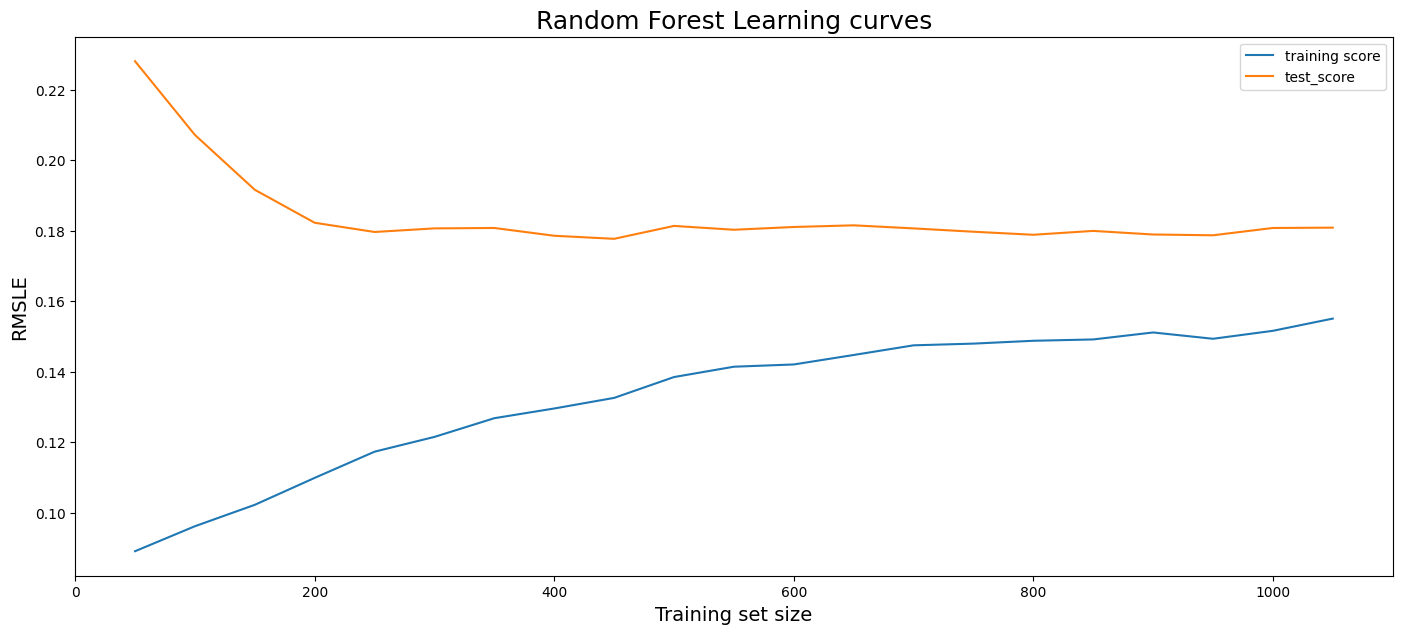

In [114]:
train_sizes = np.arange(50, 1100, 50)
train_sizes, train_scores, test_scores = learning_curve(
    estimator = rforest, 
    X = X_full, 
    y = y_full, 
    train_sizes = train_sizes, 
    cv = 5,
    scoring = RMSE
)
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)

plt.figure(figsize = (17, 7))
plt.plot(train_sizes, train_scores_mean, label = 'training score')
plt.plot(train_sizes, test_scores_mean, label = 'test_score')
plt.xlabel('Training set size', fontsize = 14)
plt.ylabel('RMSLE', fontsize = 14)
plt.title('Random Forest Learning curves', fontsize = 18)
plt.legend();

#### Hist Gradient Boost Regressor

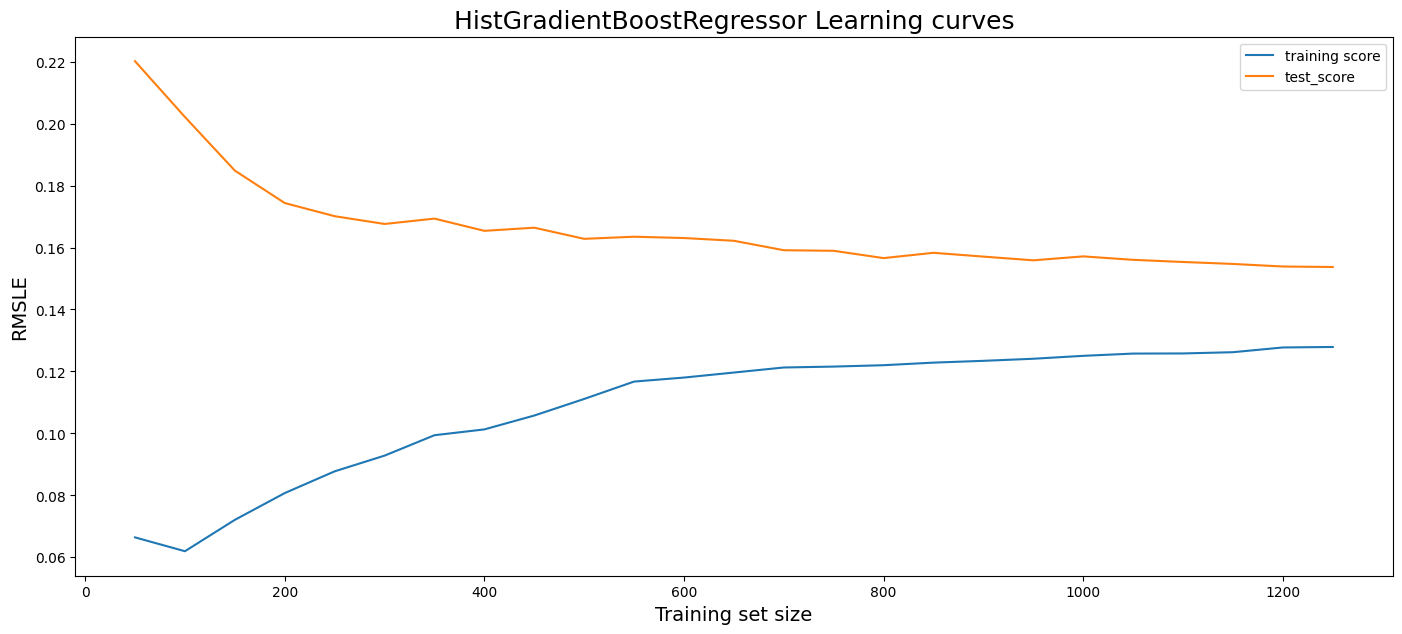

In [115]:
train_sizes = np.arange(50, 1300, 50)
train_sizes, train_scores, test_scores = learning_curve(
    estimator = hgbr, 
    X = X_full, 
    y = y_full, 
    train_sizes = train_sizes, 
    cv = 10,
    scoring = RMSE
)
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)

plt.figure(figsize = (17, 7))
plt.plot(train_sizes, train_scores_mean, label = 'training score')
plt.plot(train_sizes, test_scores_mean, label = 'test_score')
plt.xlabel('Training set size', fontsize = 14)
plt.ylabel('RMSLE', fontsize = 14)
plt.title('HistGradientBoostRegressor Learning curves', fontsize = 18)
plt.legend();

#### XGBoost

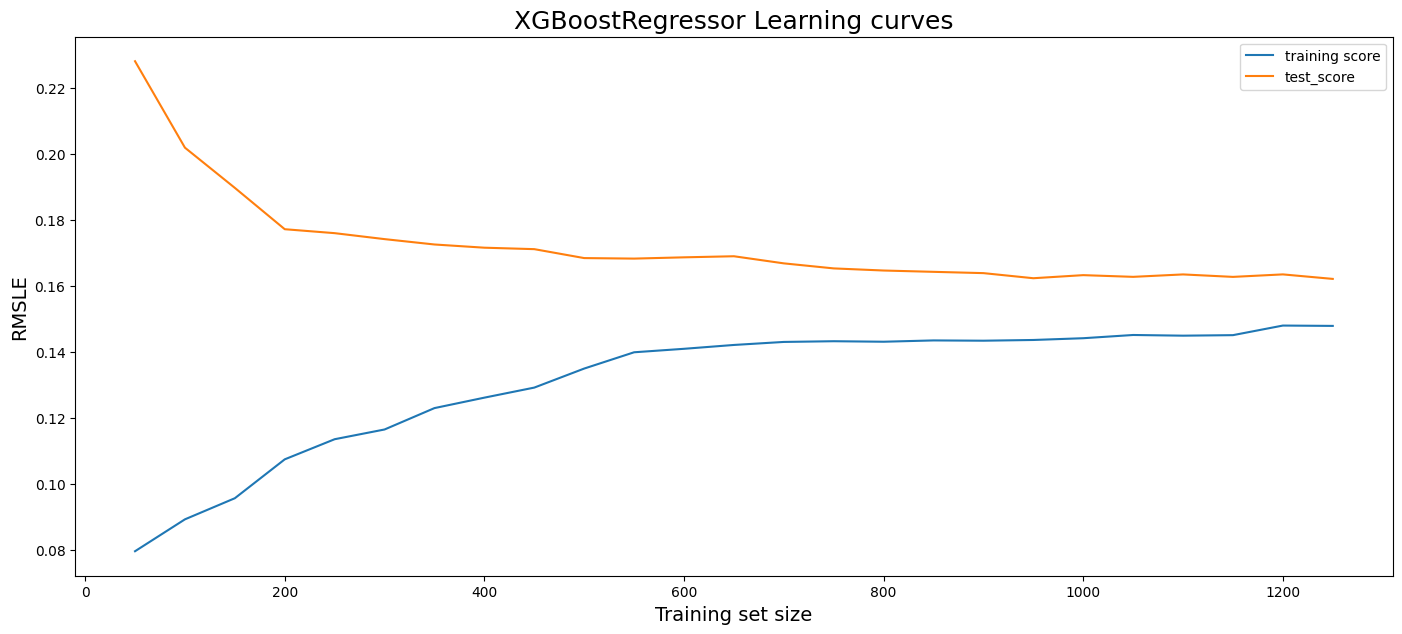

In [116]:
train_sizes = np.arange(50, 1300, 50)
train_sizes, train_scores, test_scores = learning_curve(
    estimator = xgb, 
    X = X_full, 
    y = y_full, 
    train_sizes = train_sizes, 
    cv = 10,
    scoring = RMSE
)
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)

plt.figure(figsize = (17, 7))
plt.plot(train_sizes, train_scores_mean, label = 'training score')
plt.plot(train_sizes, test_scores_mean, label = 'test_score')
plt.xlabel('Training set size', fontsize = 14)
plt.ylabel('RMSLE', fontsize = 14)
plt.title('XGBoostRegressor Learning curves', fontsize = 18)
plt.legend();

### Hyperparamaters conclusion

## Final model

### XGB

In [117]:
pipe_xgb = make_pipeline(preproc, xgb)
pipe_xgb.fit(X, y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('columntransformer-1',
                                                                   ColumnTransformer(transformers=[('minmaxscaler',
                                                                                                    MinMaxScaler(),
                                                                                                    ['YearRemodAdd',
                                                                                                     'BsmtFullBath',
                                                                                                     'FullBath',
                                                                                                     'HalfBath',
                                                                                                     'Fireplaces',
                                                                                                     'GarageYrBlt',
                                                                                                     'YrSold']),
                                                                                                   ('robustscaler',
                                                                                                    RobustScaler(),
                                                                                                    ['LotFrontage',
                                                                                                     'LotAr...
                              feature_types=None, gamma=0.05, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=2, max_leaves=None, min_child_weight=2,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=35, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

### HGBR

In [118]:
pipe_hgbr = make_pipeline(preproc, hgbr)
pipe_hgbr.fit(X, y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('columntransformer-1',
                                                                   ColumnTransformer(transformers=[('minmaxscaler',
                                                                                                    MinMaxScaler(),
                                                                                                    ['YearRemodAdd',
                                                                                                     'BsmtFullBath',
                                                                                                     'FullBath',
                                                                                                     'HalfBath',
                                                                                                     'Fireplaces',
                                                                                                     'GarageYrBlt',
                                                                                                     'YrSold']),
                                                                                                   ('robustscaler',
                                                                                                    RobustScaler(),
                                                                                                    ['LotFrontage',
                                                                                                     'LotAr...
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass', 'OverallQual',
       'OverallCond'],
      dtype='object'))])),
                                 ('selectfrommodel',
                                  SelectFromModel(estimator=RandomForestRegressor(),
                                                  threshold='median'))])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(learning_rate=0.05, max_depth=3,
                                               max_iter=60,
                                               min_samples_leaf=3))])

### Prediciting

In [119]:
X_test_ids = X_test['Id']
X_test = X_test.drop(columns =['Id'])

y_pred_xgb = pipe_xgb.predict(X_test)
y_pred_hgbr = pipe_hgbr.predict(X_test)

/opt/homebrew/Cellar/jupyterlab/4.0.9_2/libexec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.0.9_2/libexec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [120]:
results_xgb = pd.concat([X_test_ids, pd.Series(y_pred_xgb, name = 'SalePrice')], axis = 1)
results_xgb

,Id,SalePrice
0,1461,146527.015625
1,1462,191929.390625
2,1463,212773.484375
3,1464,212047.562500
4,1465,186027.125000
...,...,...
1454,2915,148589.593750
1455,2916,157388.187500
1456,2917,262629.500000
1457,2918,153567.109375


In [121]:
results_hgbr = pd.concat([X_test_ids, pd.Series(y_pred_hgbr, name = 'SalePrice')], axis = 1)
results_hgbr

,Id,SalePrice
0,1461,124184.163914
1,1462,155625.714063
2,1463,182247.876672
3,1464,177498.724107
4,1465,183576.433660
...,...,...
1454,2915,101526.728301
1455,2916,110361.206108
1456,2917,160547.306442
1457,2918,130925.452664


In [122]:
#results_xgb.to_csv('submissions/submission_xgb.csv',
               #header = True, index = False)
#results_hgbr.to_csv('submissions/submission_hgbr.csv',
               #header = True, index = False)

### Results